In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Deep Learning in Finance

## Deep Learning for Tabular Data

### How to do it...

1. Import the libraries:

In [3]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from chapter_10_utils import performance_evaluation_report, custom_set_seed

# set seed for reproducibility
custom_set_seed(42)

2. Load the dataset from a CSV file:

In [4]:
df = pd.read_csv('../Datasets/credit_card_default.csv', 
                 index_col=0, na_values='')
df.head()

limit_bal     sex   education marriage   age        payment_status_sep  \
0      20000  Female  University  Married  24.0  Payment delayed 2 months   
1     120000  Female  University   Single  26.0                Payed duly   
2      90000  Female  University   Single  34.0                   Unknown   
3      50000  Female  University  Married  37.0                   Unknown   
4      50000    Male  University  Married  57.0                Payed duly   

         payment_status_aug payment_status_jul payment_status_jun  \
0  Payment delayed 2 months         Payed duly         Payed duly   
1  Payment delayed 2 months            Unknown            Unknown   
2                   Unknown            Unknown            Unknown   
3                   Unknown            Unknown            Unknown   
4                   Unknown         Payed duly            Unknown   

  payment_status_may  ... bill_statement_jun  bill_statement_may  \
0            Unknown  ...                  0                   0   
1            Unknown  ...               3272                3455   
2            Unknown  ...              14331               14948   
3            Unknown  ...              28314               28959   
4            Unknown  ...              20940               19146   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0                   0                     0                   689   
1                3261                     0                  1000   
2               15549                  1518                  1500   
3               29547                  2000                  2019   
4               19131                  2000                 36681   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0                     0                     0                     0   
1                  1000                  1000                     0   
2                  1000                  1000                  1000   
3                  1200                  1100                  1069   
4                 10000                  9000                   689   

   previous_payment_apr  default_payment_next_month  
0                     0                           1  
1                  2000                           1  
2                  5000                           0  
3                  1000                           0  
4                   679                           0  

[5 rows x 24 columns]

3. Identify the dependent variable (target) and numerical/categorical features:

In [5]:
DEP_VAR = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(DEP_VAR)
cat_features = list(df.select_dtypes('object').columns)

preprocessing = [FillMissing, Categorify, Normalize]

4. Create a `TabularDataBunch` from the DataFrame:

In [6]:
data = (TabularList.from_df(df, 
                            cat_names=cat_features,
                            cont_names=num_features, 
                            procs=preprocessing)
                   .split_by_rand_pct(valid_pct=0.2, seed=42)
                   .label_from_df(cols=DEP_VAR)
                   .databunch())

We additionally inspect a few rows from the DataBunch:

In [7]:
data.show_batch(rows=5)

5. Define the `Learner` object:

In [8]:
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.001,0.01], 
                        emb_drop=0.04, 
                        metrics=[Recall(), 
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

6. Inspect the model's architecture:

In [9]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=2, bias=True)
  )
)

`Embedding(11, 6)` means that a categorical embedding was created with 11 input values and 6 output latent features.

7. Find the suggested learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-03


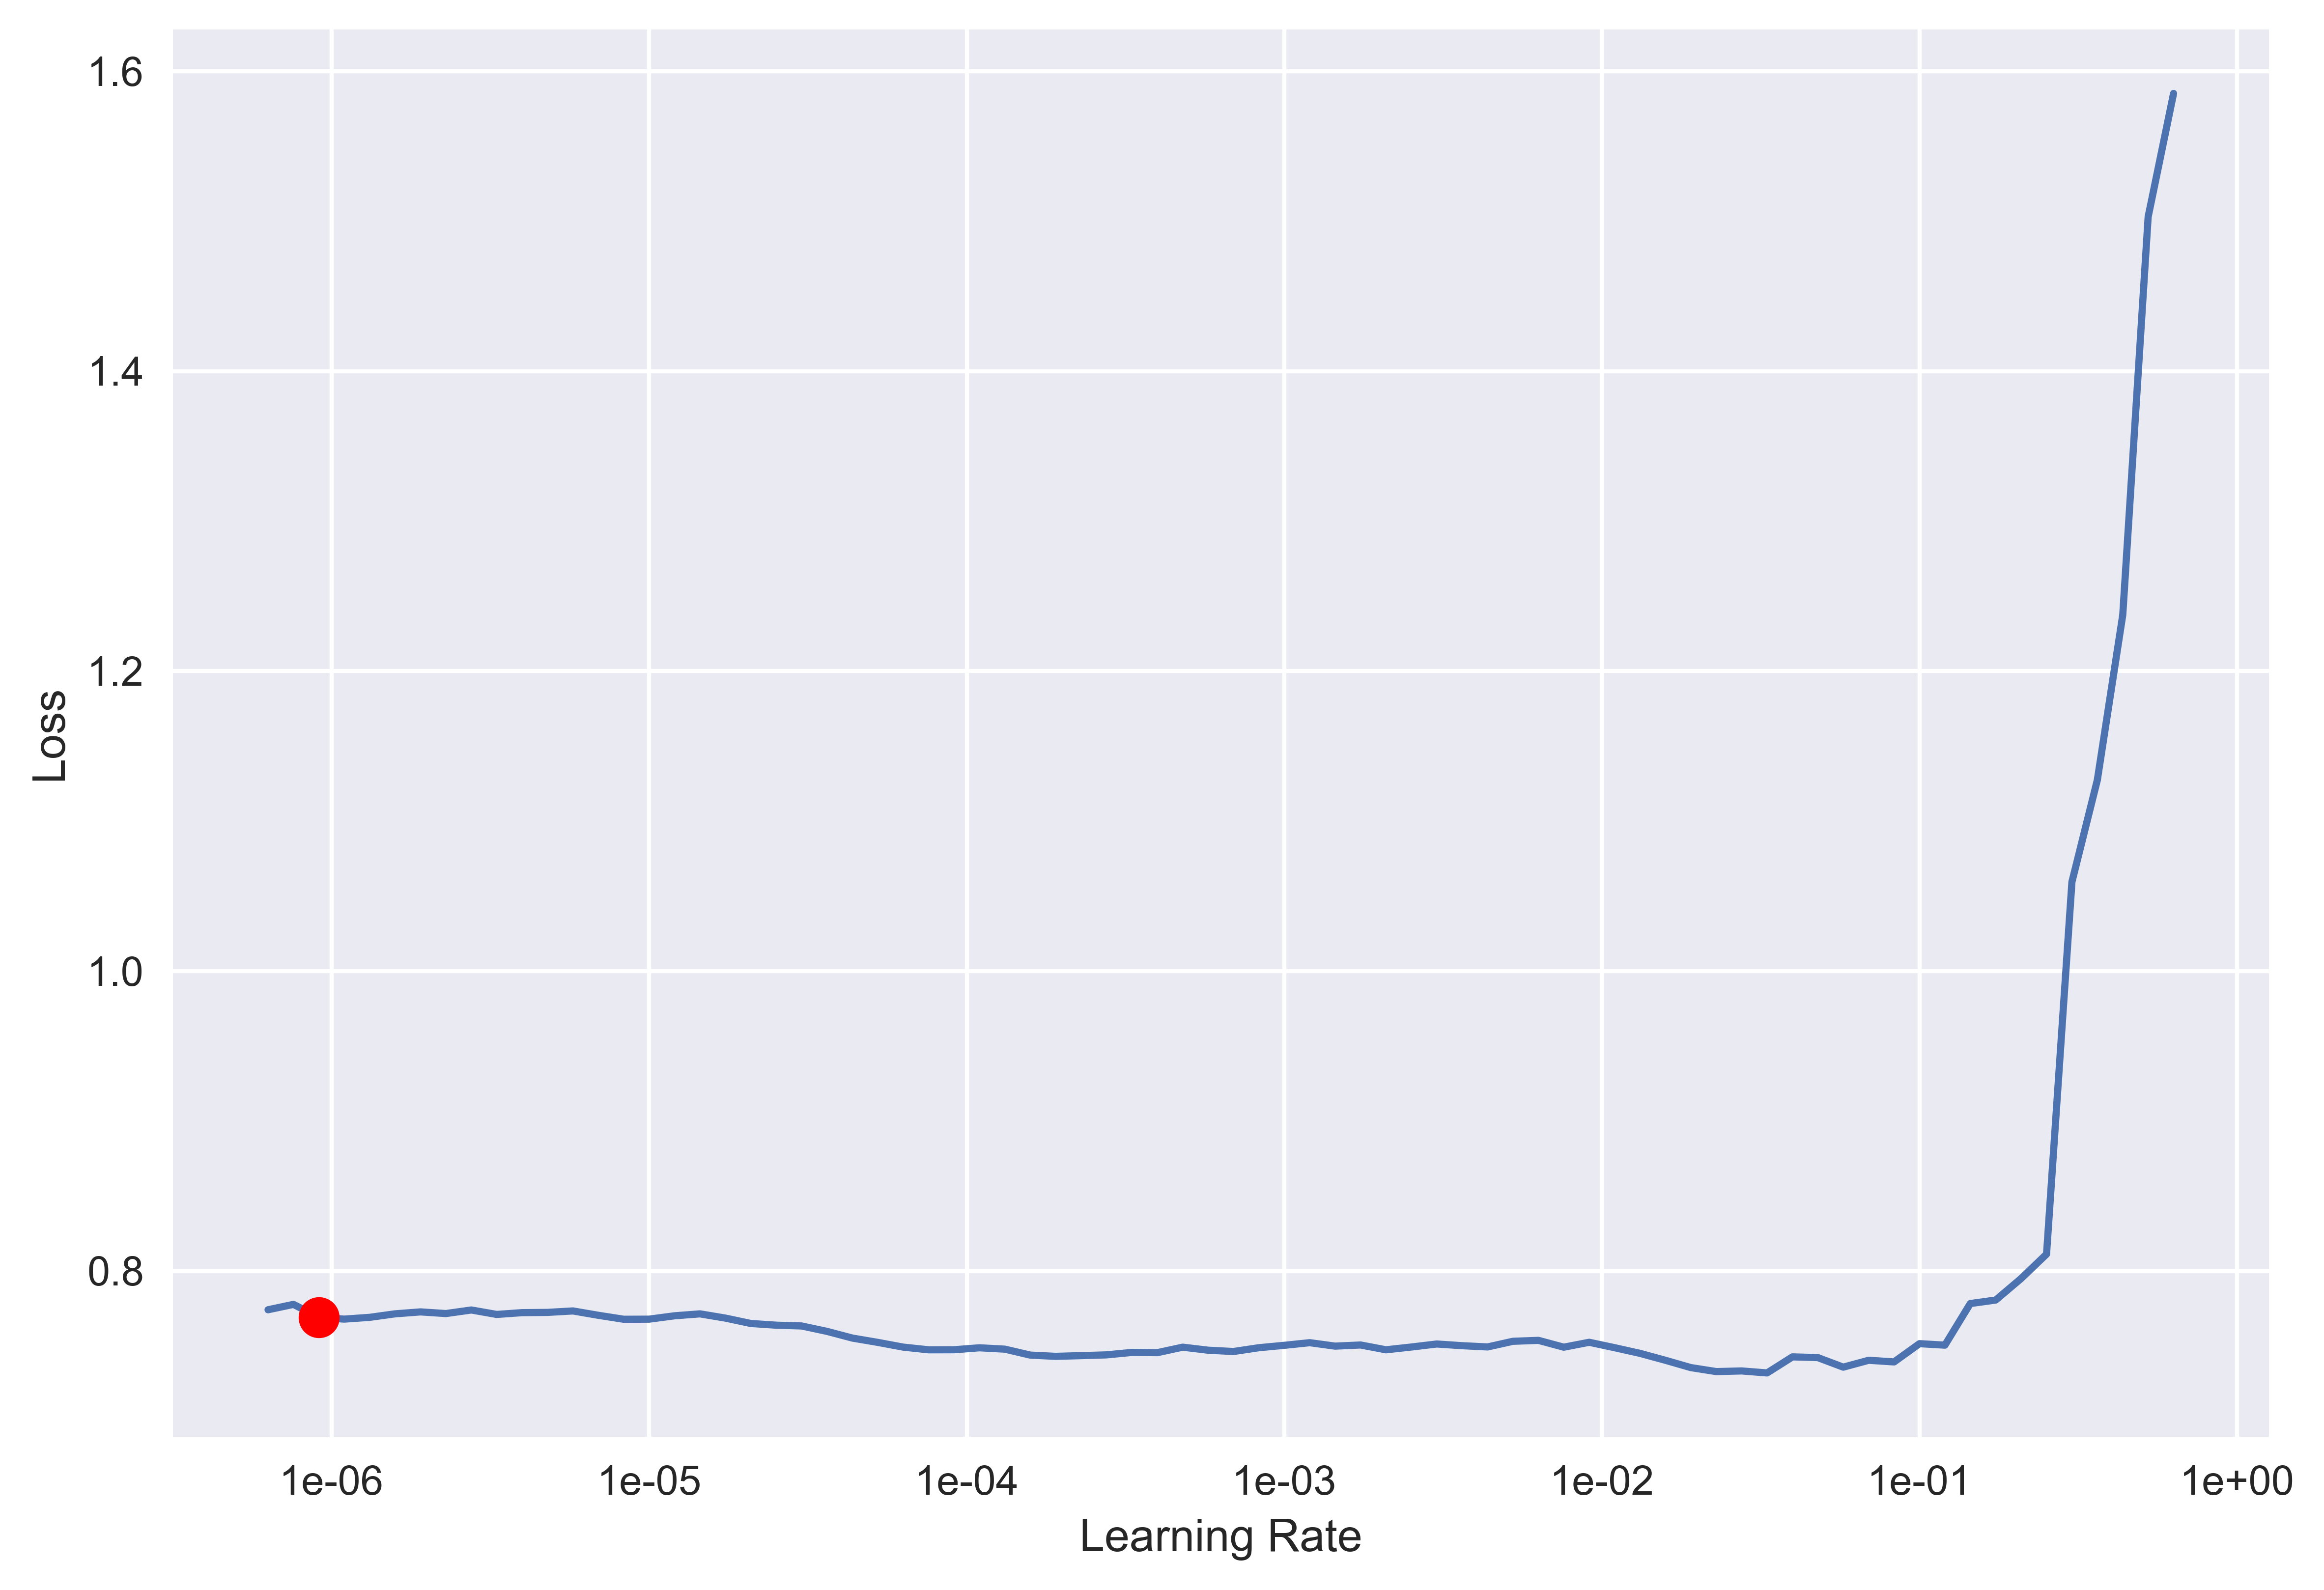

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# plt.tight_layout()
# plt.savefig('images/ch10_im2.png')
plt.show()

8. Train the Neural Network:

In [11]:
learn.fit(epochs=25, lr=1e-6, wd=0.2)

9. Plot the losses:

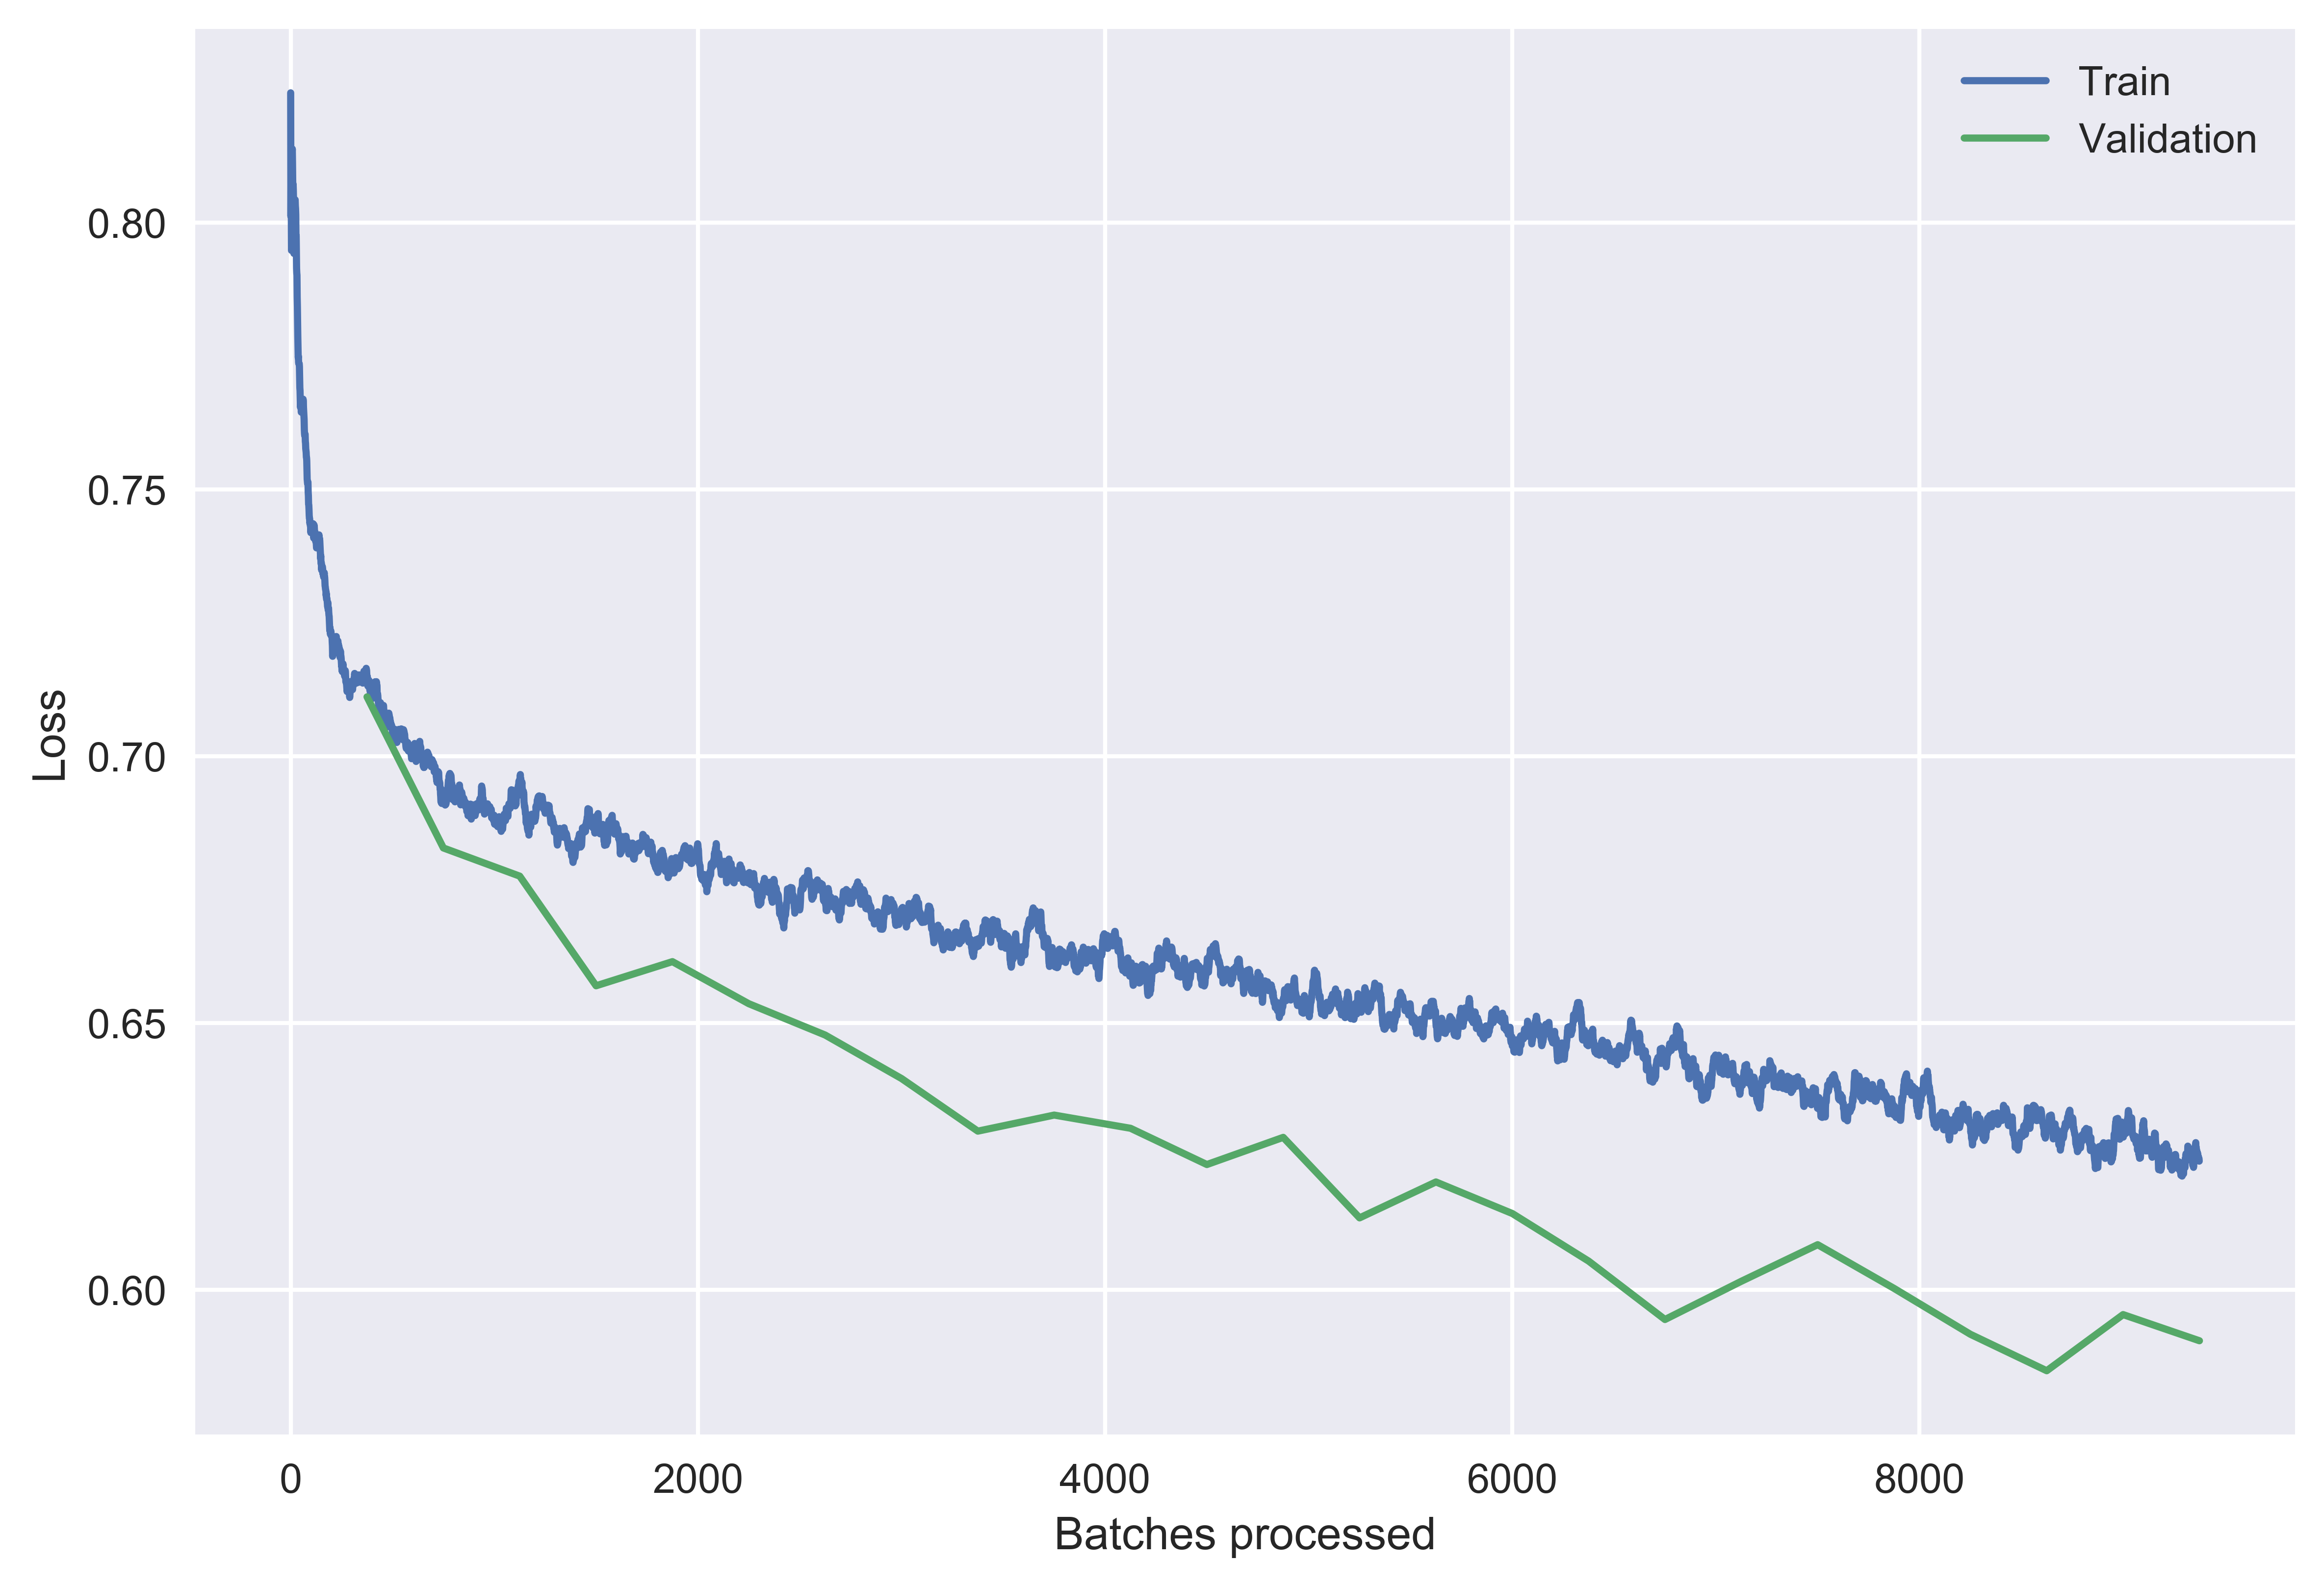

In [12]:
learn.recorder.plot_losses()

# plt.tight_layout()
# plt.savefig('images/ch10_im4.png')
plt.show()

10. Extract the predictions for the validation set:

In [13]:
preds_valid, _ = learn.get_preds(ds_type=DatasetType.Valid)
pred_valid = preds_valid.argmax(dim=-1)

11. Inspect the performance (confusion matrix) on the validation set:

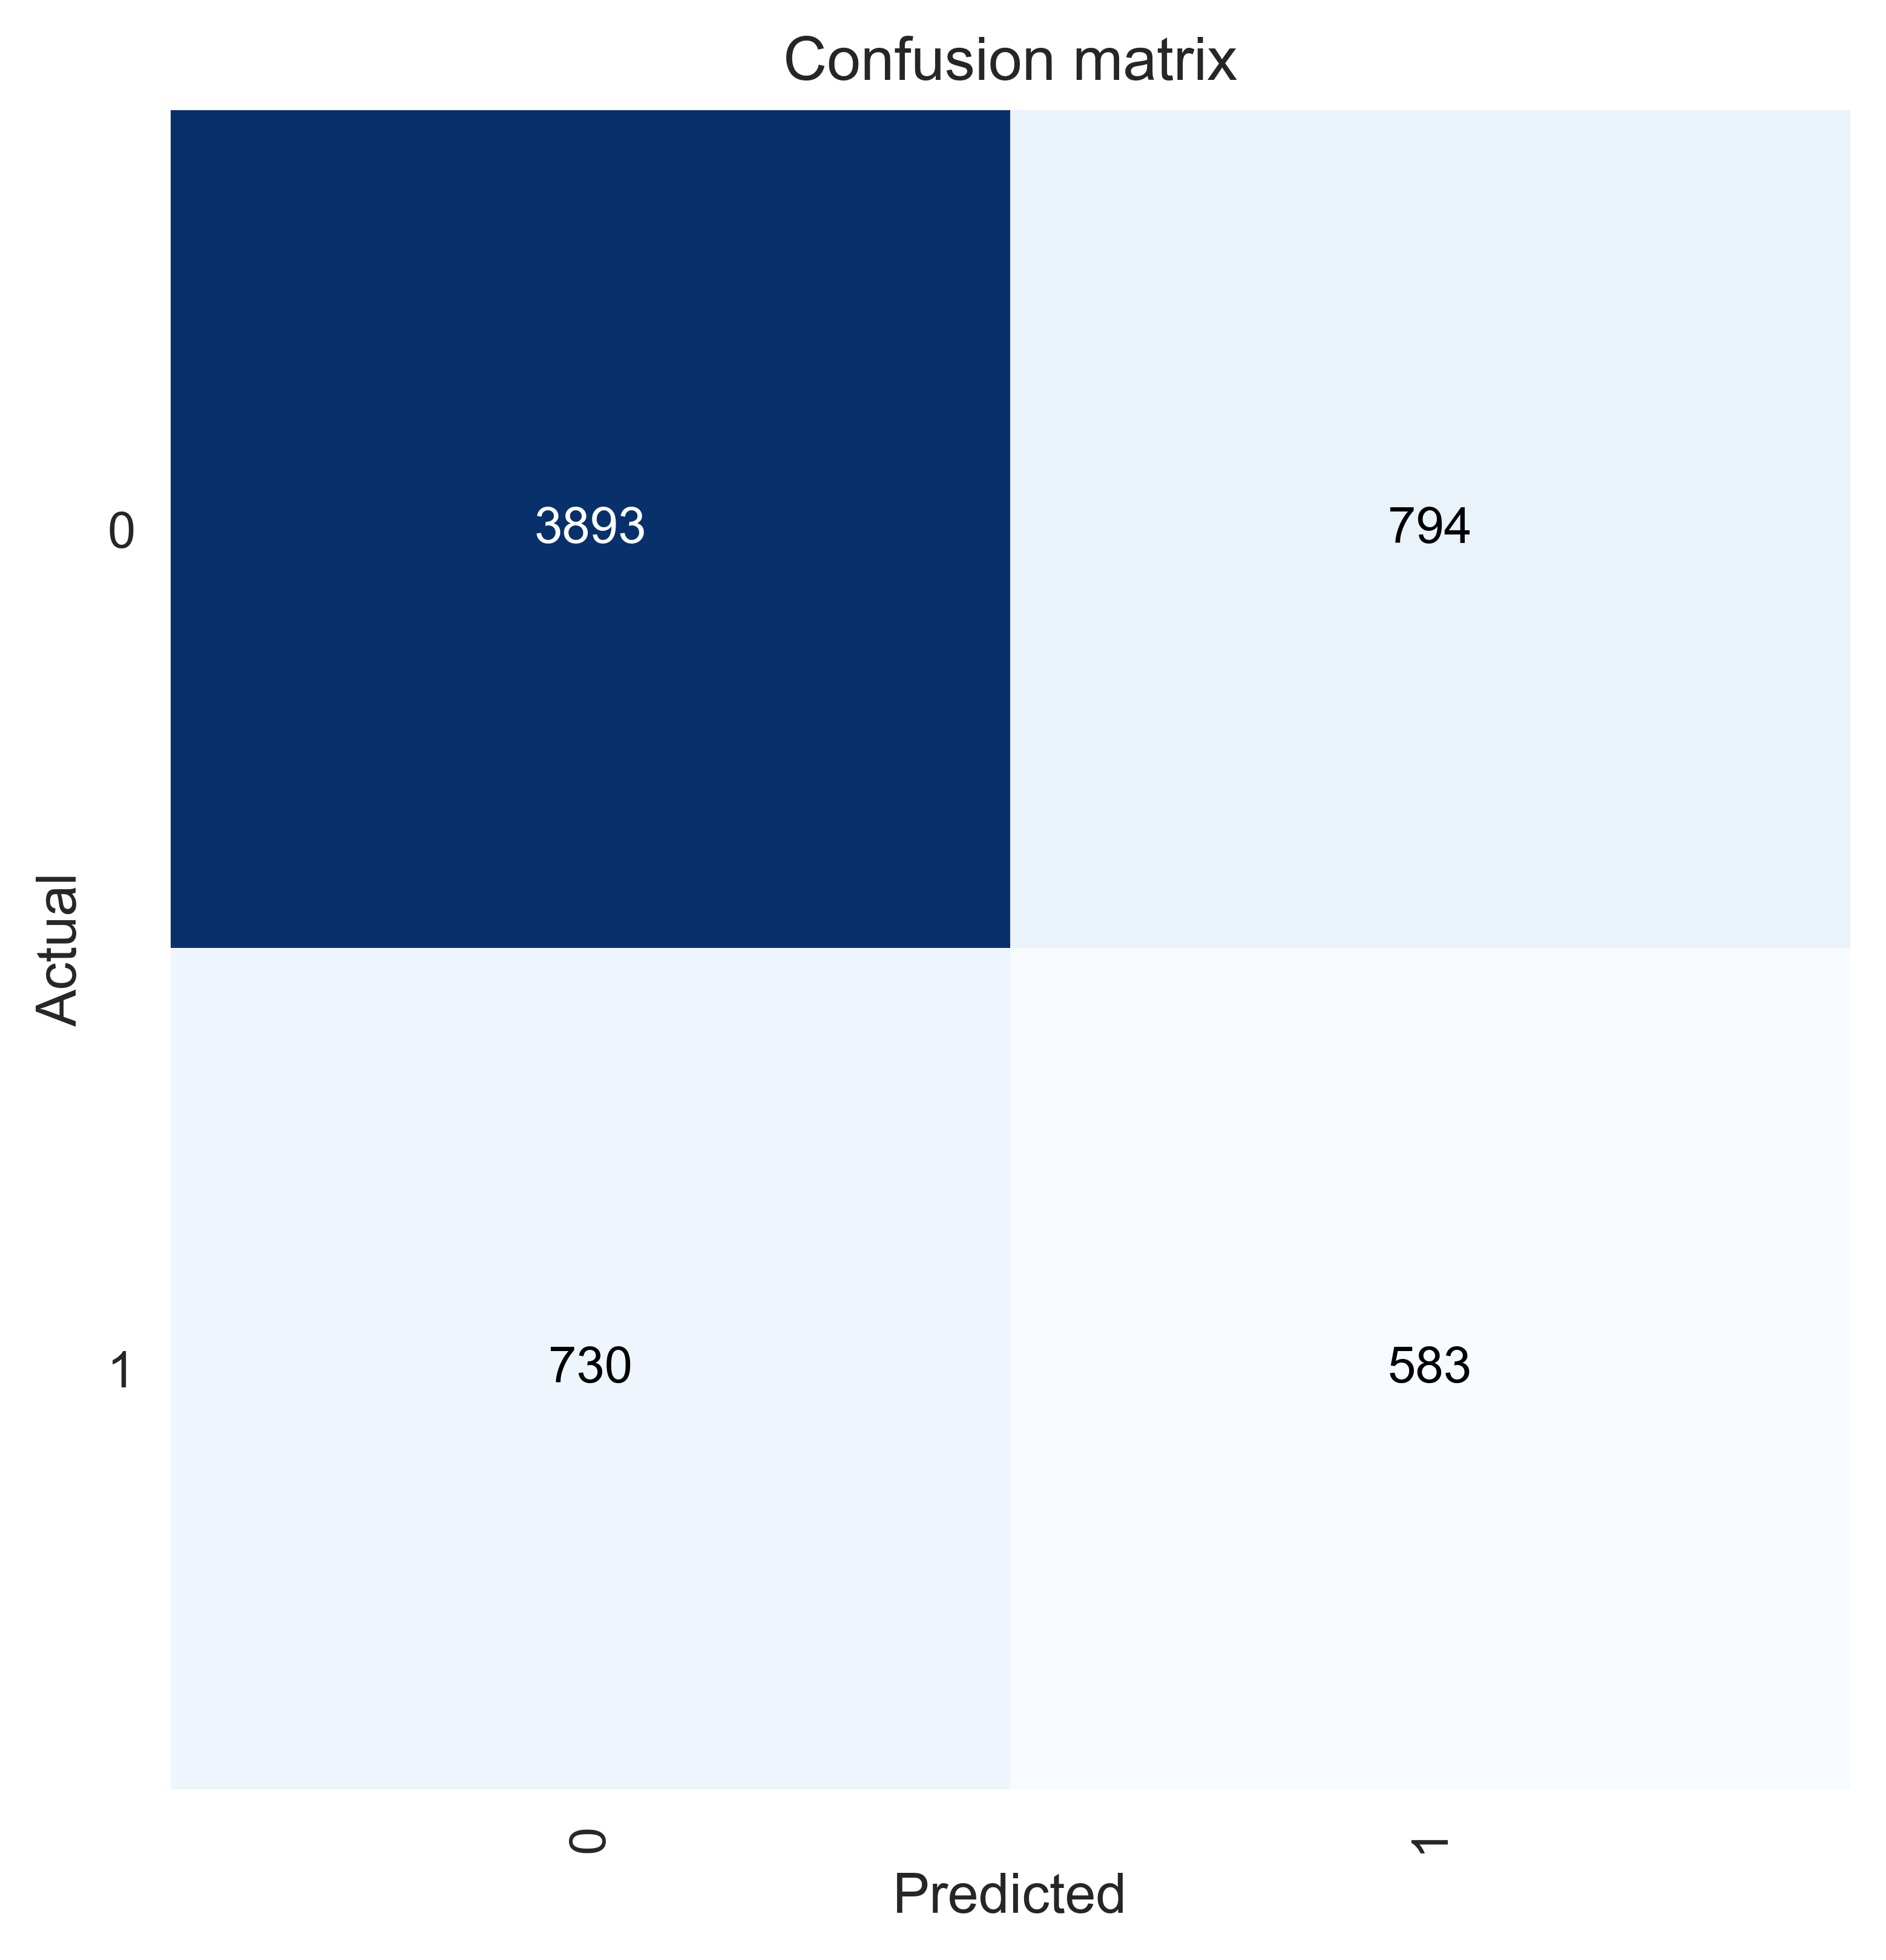

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# plt.tight_layout()
# plt.savefig('images/ch10_im5.png')
plt.show()

In [15]:
interp.plot_tab_top_losses(5)

Prediction Actual  Loss Probability     sex   education marriage  \
0          1      0  2.36        0.09    Male      school  Married   
1          1      0  2.21        0.11  Female      school  Married   
2          1      0  1.98        0.14  Female  University  Married   
3          1      0  1.77        0.17  Female  University   Single   
4          1      0  1.70        0.18    Male      school  Married   

  payment_status_sep payment_status_aug payment_status_jul  ...  \
0            Unknown            Unknown            Unknown  ...   
1            Unknown            Unknown            Unknown  ...   
2            Unknown            Unknown            Unknown  ...   
3               duly               duly               duly  ...   
4            Unknown            Unknown             months  ...   

  bill_statement_jul bill_statement_jun bill_statement_may bill_statement_apr  \
0             6.3022             6.8174             7.4057             7.5982   
1             9.2813            10.3614             5.6569             4.3163   
2             3.6990             4.0111             5.9346            -0.6539   
3             3.4416             3.2220             3.0127            -0.6505   
4             6.4275             6.0500             5.5496             5.3620   

  previous_payment_sep previous_payment_aug previous_payment_jul  \
0               0.8387               0.7428               0.3147   
1               1.3363               1.0105               1.3563   
2               0.3119               0.3659               0.0407   
3              -0.3319              11.4963              -0.0148   
4               2.0108              -0.2321               0.5502   

  previous_payment_jun previous_payment_may previous_payment_apr  
0               0.3140              -0.3085               0.3345  
1               0.6206               0.6518              -0.2955  
2               5.8338              -0.3085              15.7000  
3              -0.2932              -0.2957              29.9856  
4               0.4450               0.4797               0.5128  

[5 rows x 28 columns]

12. Inspect the performance evaluation metrics:

In [16]:
performance_evaluation_report(learn)

{'accuracy': 0.746,
 'precision': 0.4233841684822077,
 'recall': 0.44402132520944404,
 'specificity': 0.8305952634947728,
 'f1_score': 0.433457249070632,
 'cohens_kappa': 0.2698817102973029,
 'roc_auc': 0.7060126931437297,
 'pr_auc': 0.40368381260070746}

### There's more

In [ ]:
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(DEP_VAR)

train_ind, test_ind = next(StratifiedKFold(n_splits=5).split(X, y))

data = (TabularList.from_df(df, 
                            cat_names=cat_features,
                            cont_names=num_features, 
                            procs=preprocessing)
                   .split_by_idxs(train_idx=list(train_ind), 
                                  valid_idx=list(test_ind)) 
                   .label_from_df(cols=DEP_VAR)
                   .databunch())

## Multilayer perceptrons for time series forecasting

### How to do it...

1. Import the libraries:

In [2]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset)

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.3.1


2. Define parameters:

In [3]:
# data
TICKER = 'ANF'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
N_LAGS = 3

# neural network 
VALID_SIZE = 12
BATCH_SIZE = 5
N_EPOCHS = 1000

3. Download and prepare the data:

In [4]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('M').last()
prices = df['Adj Close'].values

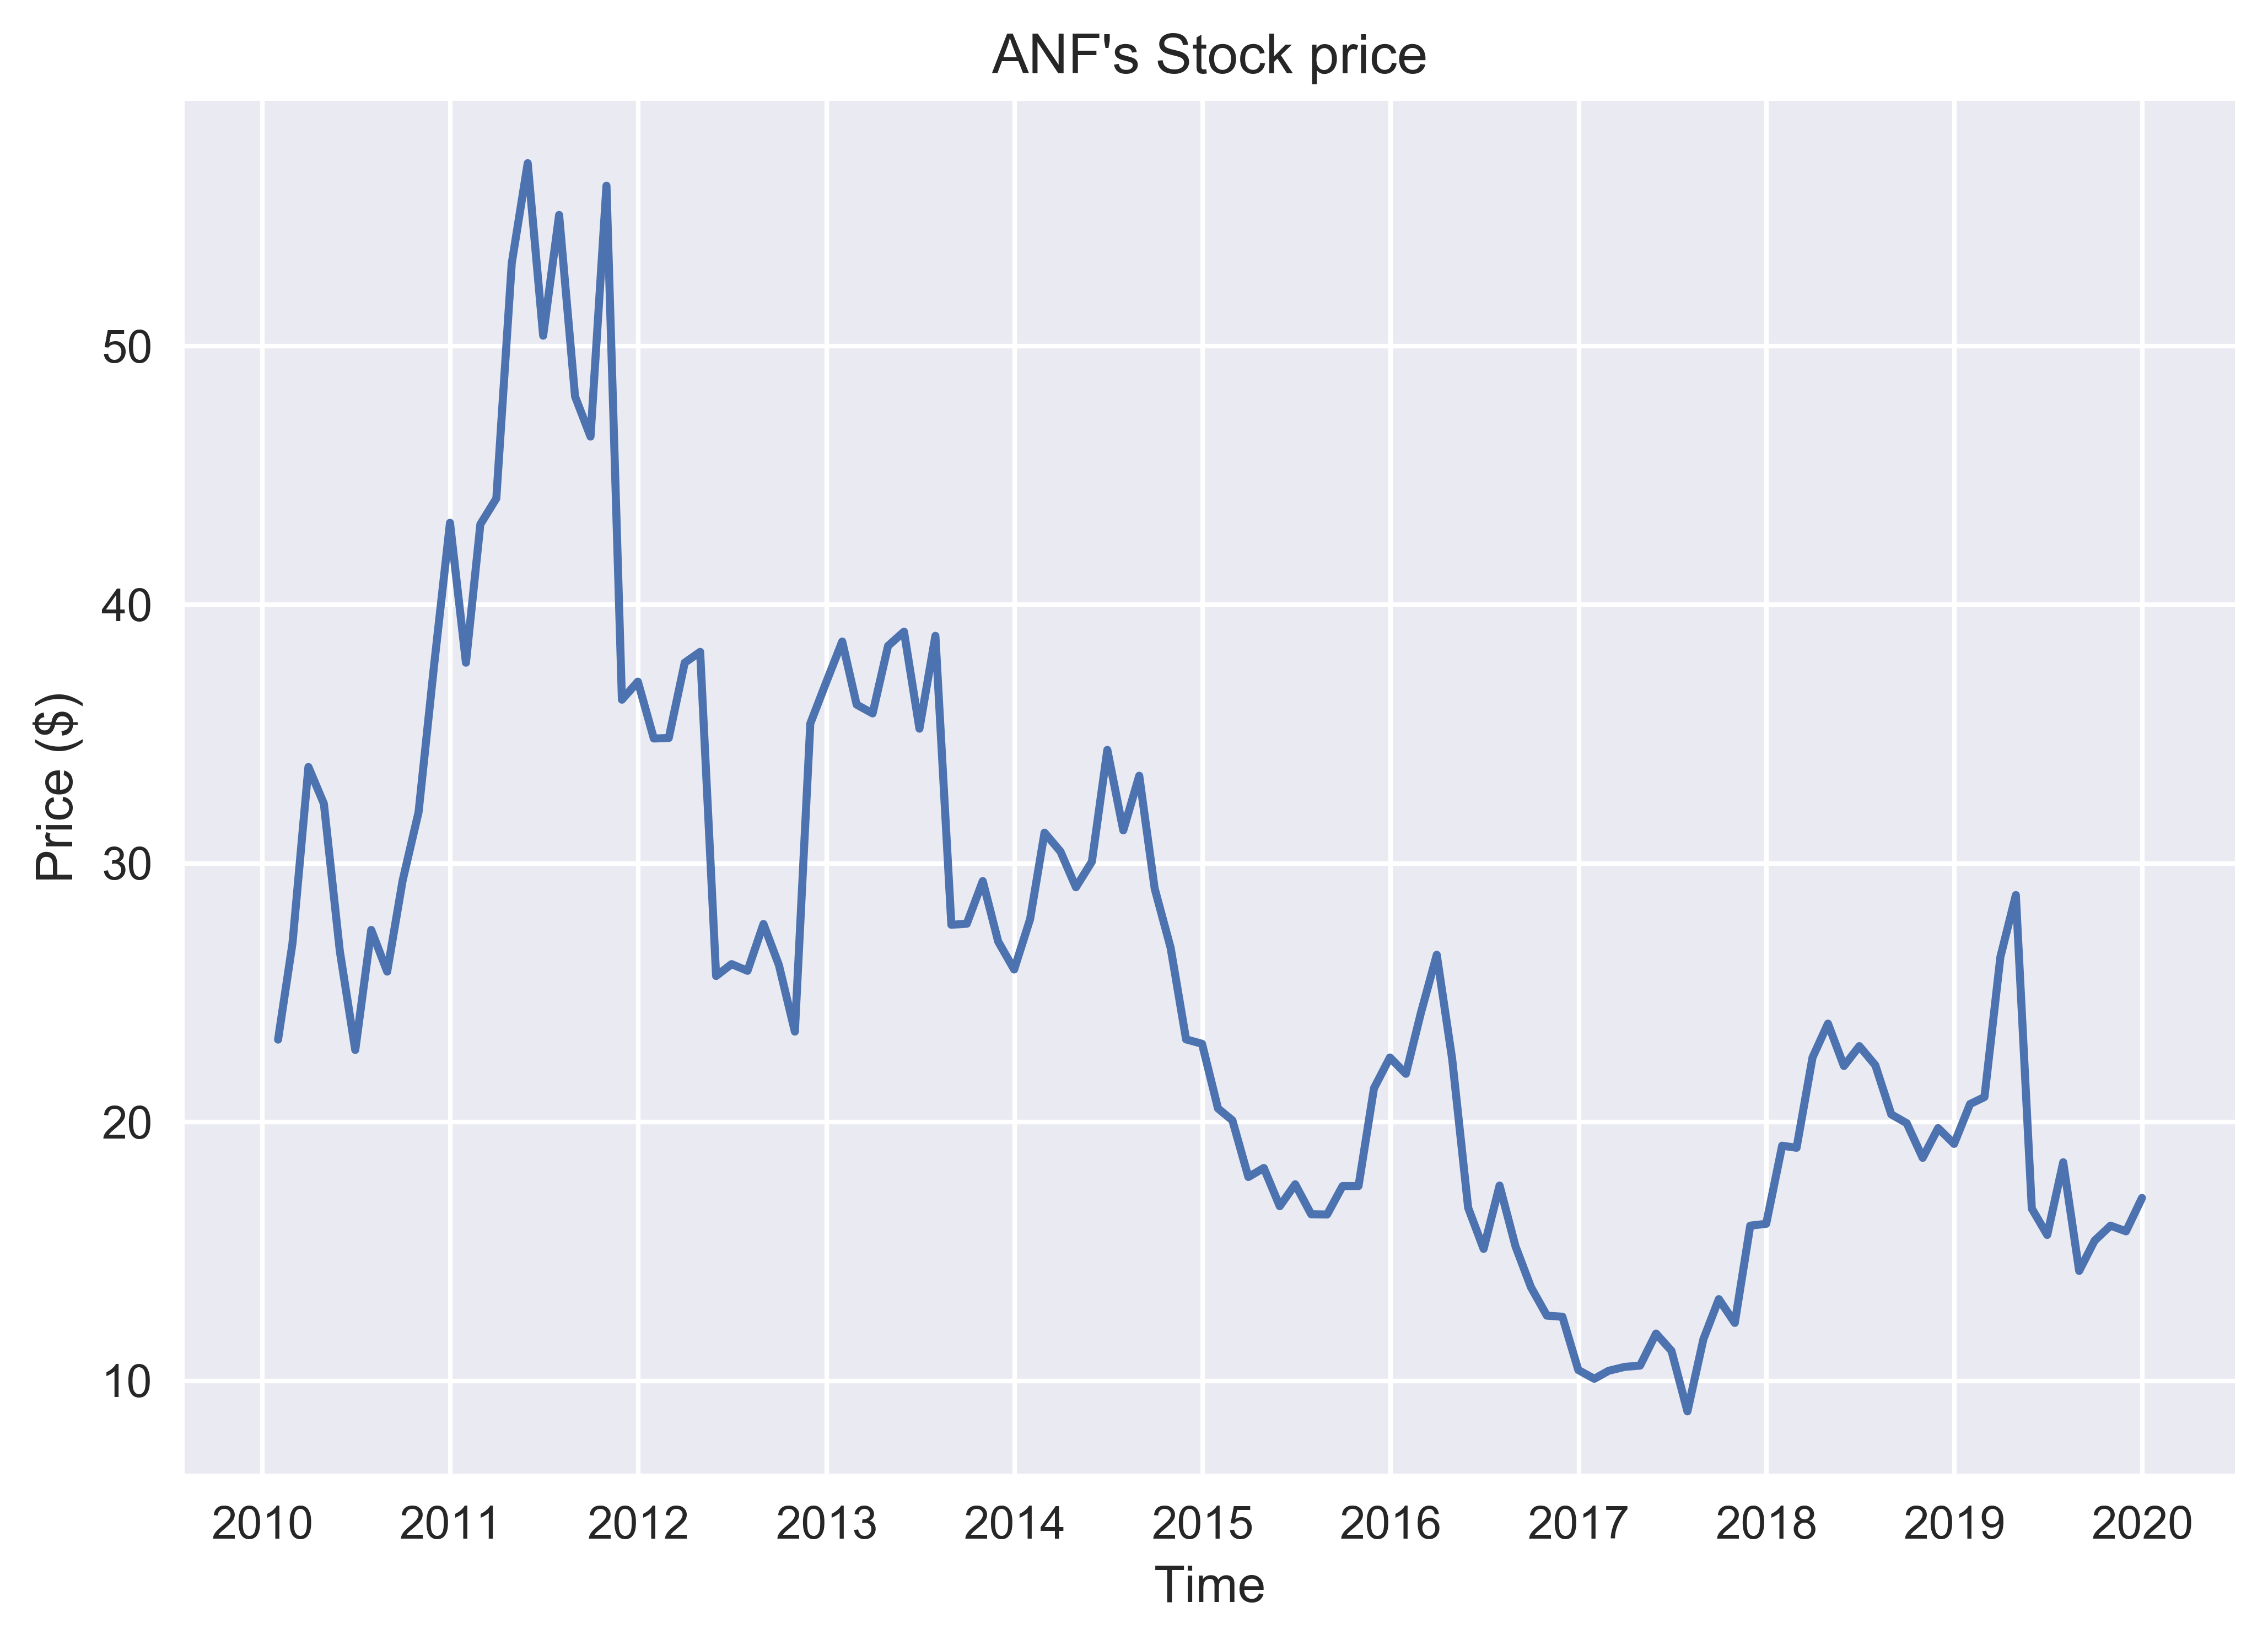

In [6]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Define a function for transforming time series into a dataset for the MLP:

In [7]:
def create_input_data(series, n_lags=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features

    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X, y = [], []

    for step in range(len(series) - n_lags):
        end_step = step + n_lags
        X.append(series[step:end_step])
        y.append(series[end_step])
    return np.array(X), np.array(y)

5. Transform the considered time series into input for the MLP:

In [8]:
X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

6. Create training and validation sets:

In [9]:
valid_ind = len(X) - VALID_SIZE

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Inspect the observations from the first batch:

In [10]:
next(iter(train_loader))[0]

tensor([[23.1900, 26.9100, 33.7300],
        [26.9100, 33.7300, 32.3100],
        [33.7300, 32.3100, 26.6100],
        [32.3100, 26.6100, 22.7900],
        [26.6100, 22.7900, 27.4300]])

In [11]:
next(iter(train_loader))[1]

tensor([[32.3100],
        [26.6100],
        [22.7900],
        [27.4300],
        [25.8200]])

Check the size of the datasets:

In [12]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 105 | validation: 12


7. Use naive forecast as a benchmark and evaluate the performance:

In [13]:
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 17.87, RMSE: 4.23


In [14]:
# BONUS: Testing Linear Regression

# from sklearn.linear_model import LinearRegression

# X_train = X[:valid_ind, ]
# y_train = y[:valid_ind]

# X_valid = X[valid_ind:, ]
# y_valid = y[valid_ind:]

# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)

# y_pred = lin_reg.predict(X_valid)
# lr_mse = mean_squared_error(y_valid, y_pred)
# lr_rmse = np.sqrt(lr_mse)
# print(f"Linear Regression's forecast - MSE: {lr_mse:.2f}, RMSE: {lr_rmse:.2f}")
# print(f"Linear Regression's coefficients: {lin_reg.coef_}")

# fig, ax = plt.subplots()

# ax.plot(y_valid, color='blue', label='Actual')
# ax.plot(y_pred, color='red', label='Prediction')

# ax.set(title="Linear Regression's Forecasts", 
#        xlabel='Time', 
#        ylabel='Price ($)')
# ax.legend();

8. Define the network's architecture:

In [15]:
class MLP(nn.Module):
   
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.linear2 = nn.Linear(8, 4)
        self.linear3 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

9. Instantiate the model, the loss function and the optimizer:

In [16]:
# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
model

MLP(
  (linear1): Linear(in_features=3, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

10. Train the network:

In [18]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 1052.29 	 Valid. loss: 432.18
<50> - Train. loss: 173.09 	 Valid. loss: 21.80
<100> - Train. loss: 126.82 	 Valid. loss: 18.49
<150> - Train. loss: 97.87 	 Valid. loss: 20.98
<200> - Train. loss: 68.56 	 Valid. loss: 17.96
<250> - Train. loss: 139.01 	 Valid. loss: 17.69
<300> - Train. loss: 116.76 	 Valid. loss: 16.27
<350> - Train. loss: 89.38 	 Valid. loss: 16.87
<400> - Train. loss: 108.84 	 Valid. loss: 17.16
<450> - Train. loss: 91.19 	 Valid. loss: 17.08
<500> - Train. loss: 62.95 	 Valid. loss: 16.86
<550> - Train. loss: 115.60 	 Valid. loss: 16.38
<600> - Train. loss: 106.46 	 Valid. loss: 16.28
<650> - Train. loss: 81.98 	 Valid. loss: 16.01
<700> - Train. loss: 80.78 	 Valid. loss: 16.90
<750> - Train. loss: 61.36 	 Valid. loss: 16.70
<800> - Train. loss: 79.77 	 Valid. loss: 15.98
<850> - Train. loss: 95.74 	 Valid. loss: 15.84
<900> - Train. loss: 85.65 	 Valid. loss: 16.00
<950> - Train. loss: 94.79 	 Valid. loss: 16.23
Lowest loss recorded in epoch: 96

11. Plot the losses over epochs:

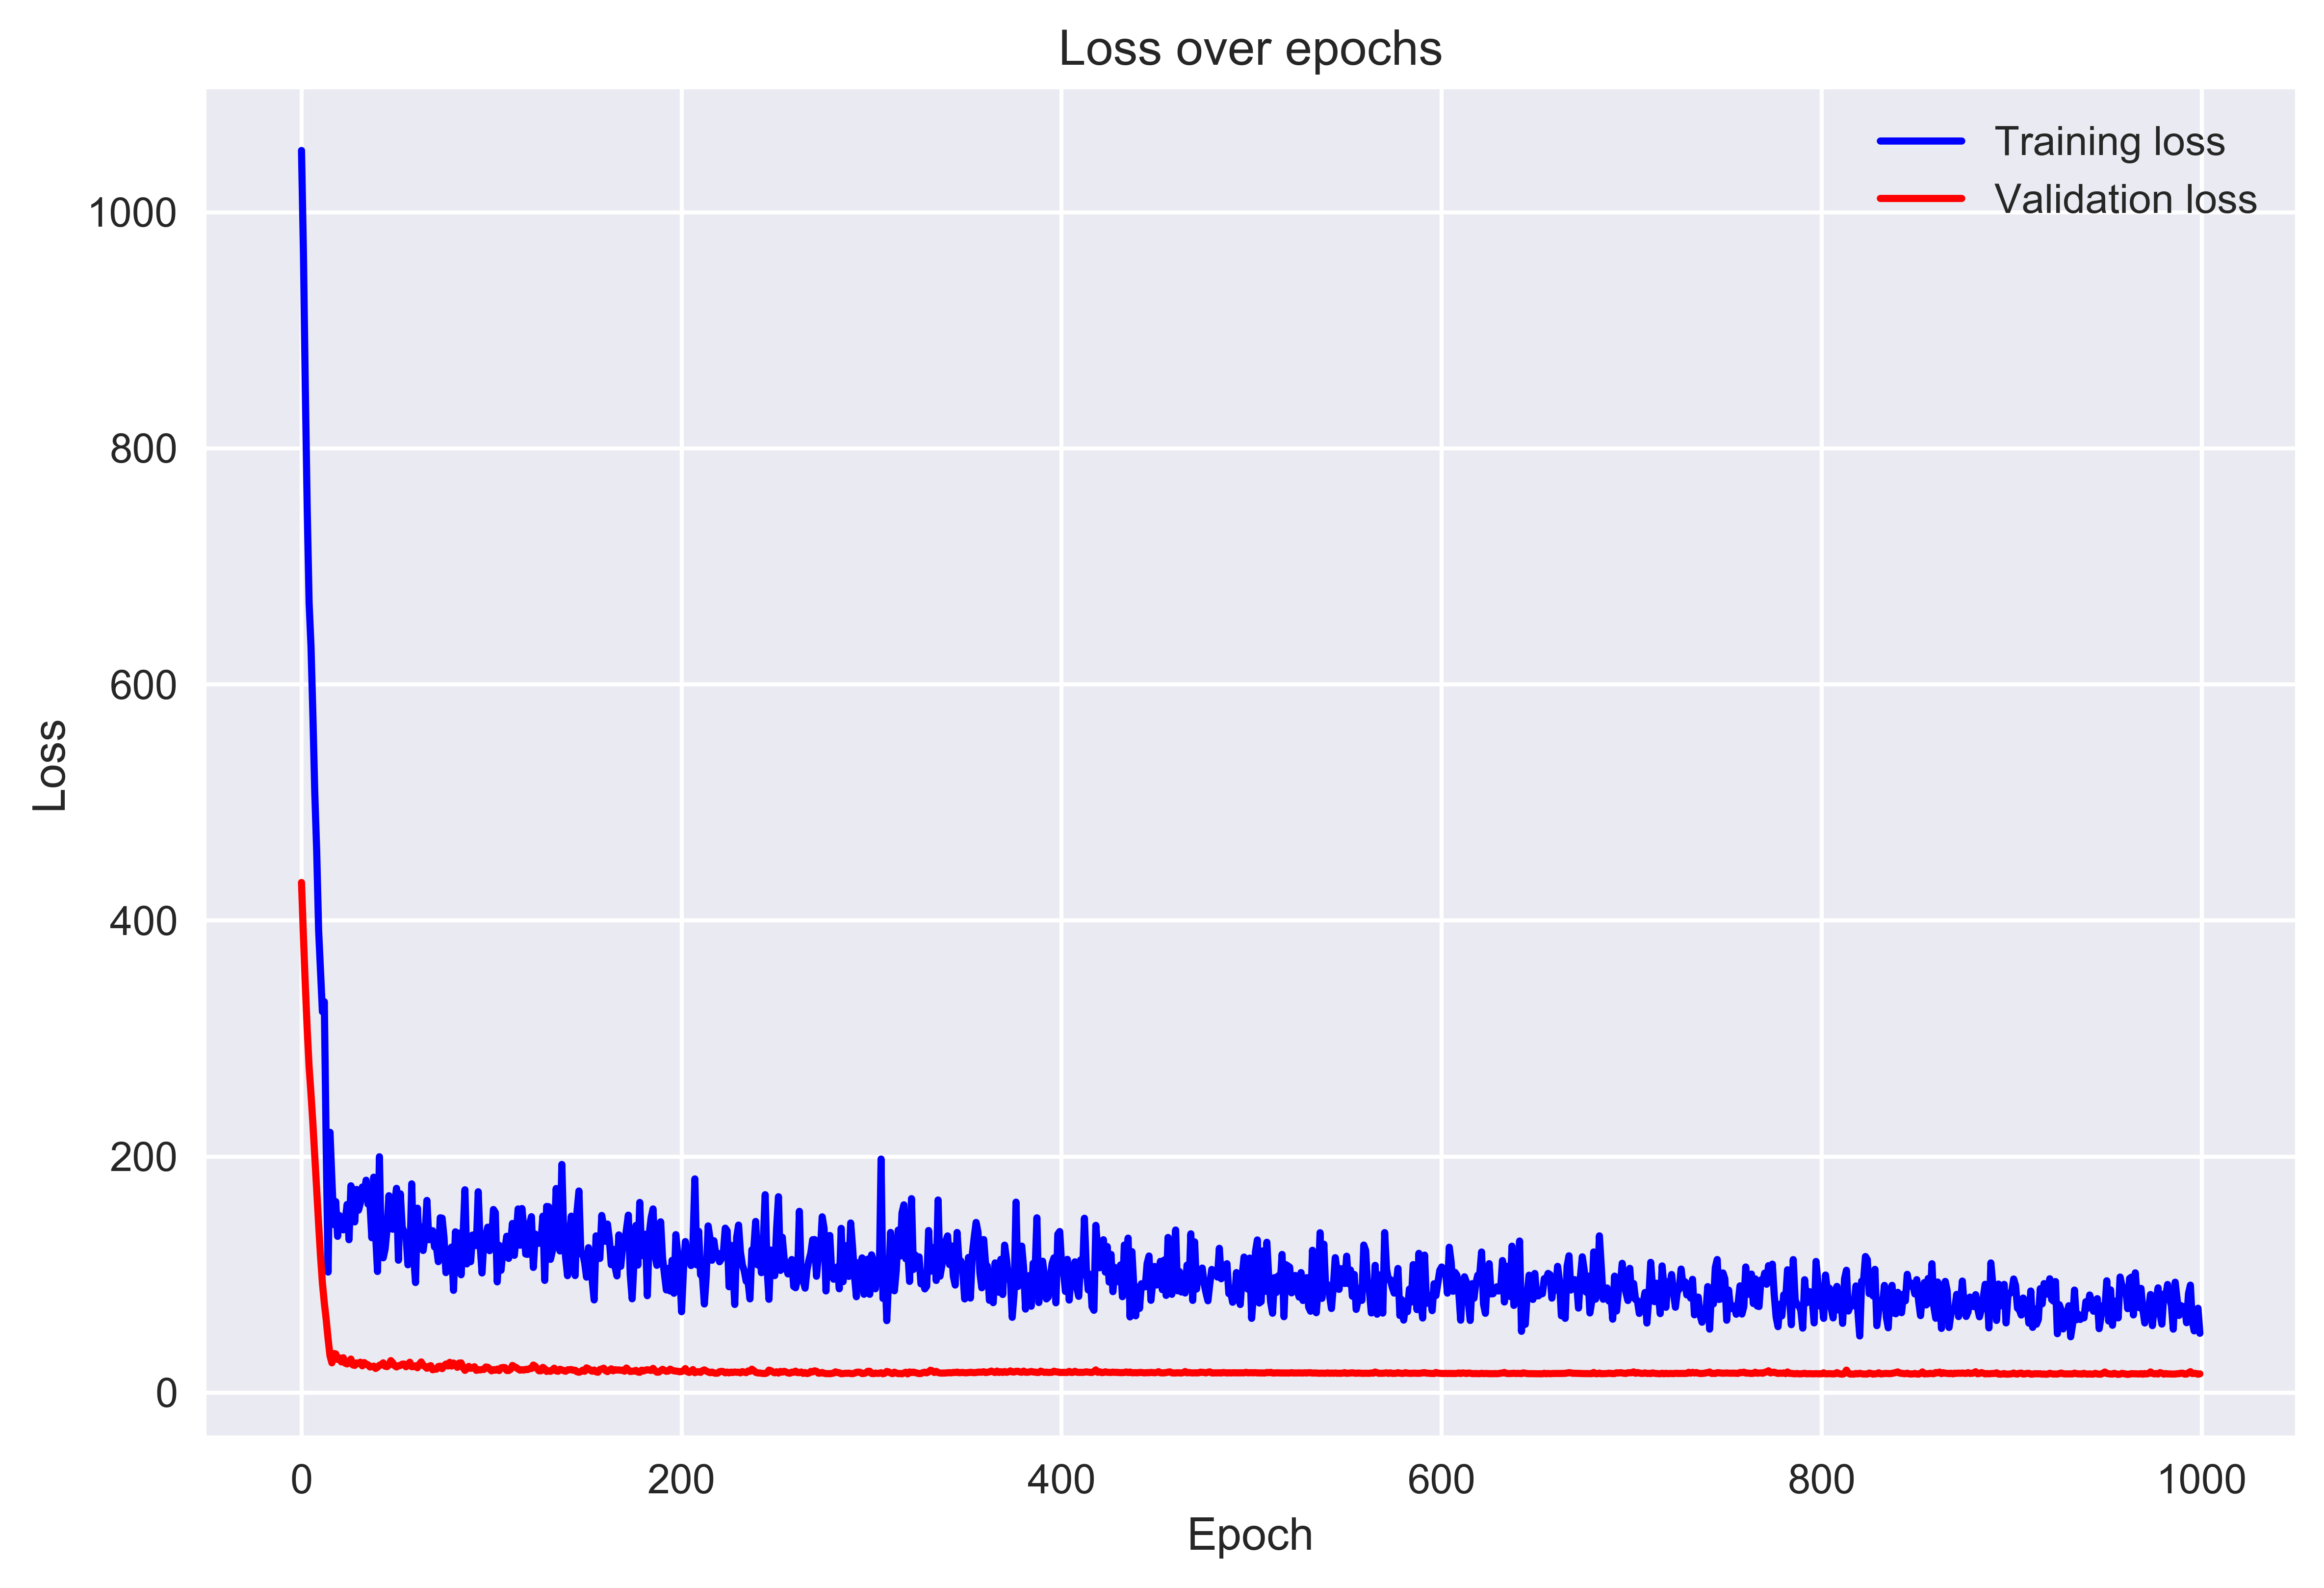

In [20]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs', 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im7.png')
plt.show()

12. Load the best model (with the lowest validation loss):

In [21]:
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

13. Obtain the predictions:

In [22]:
y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

14. Evaluate the predictions:

MLP's forecast - MSE: 15.47, RMSE: 3.93


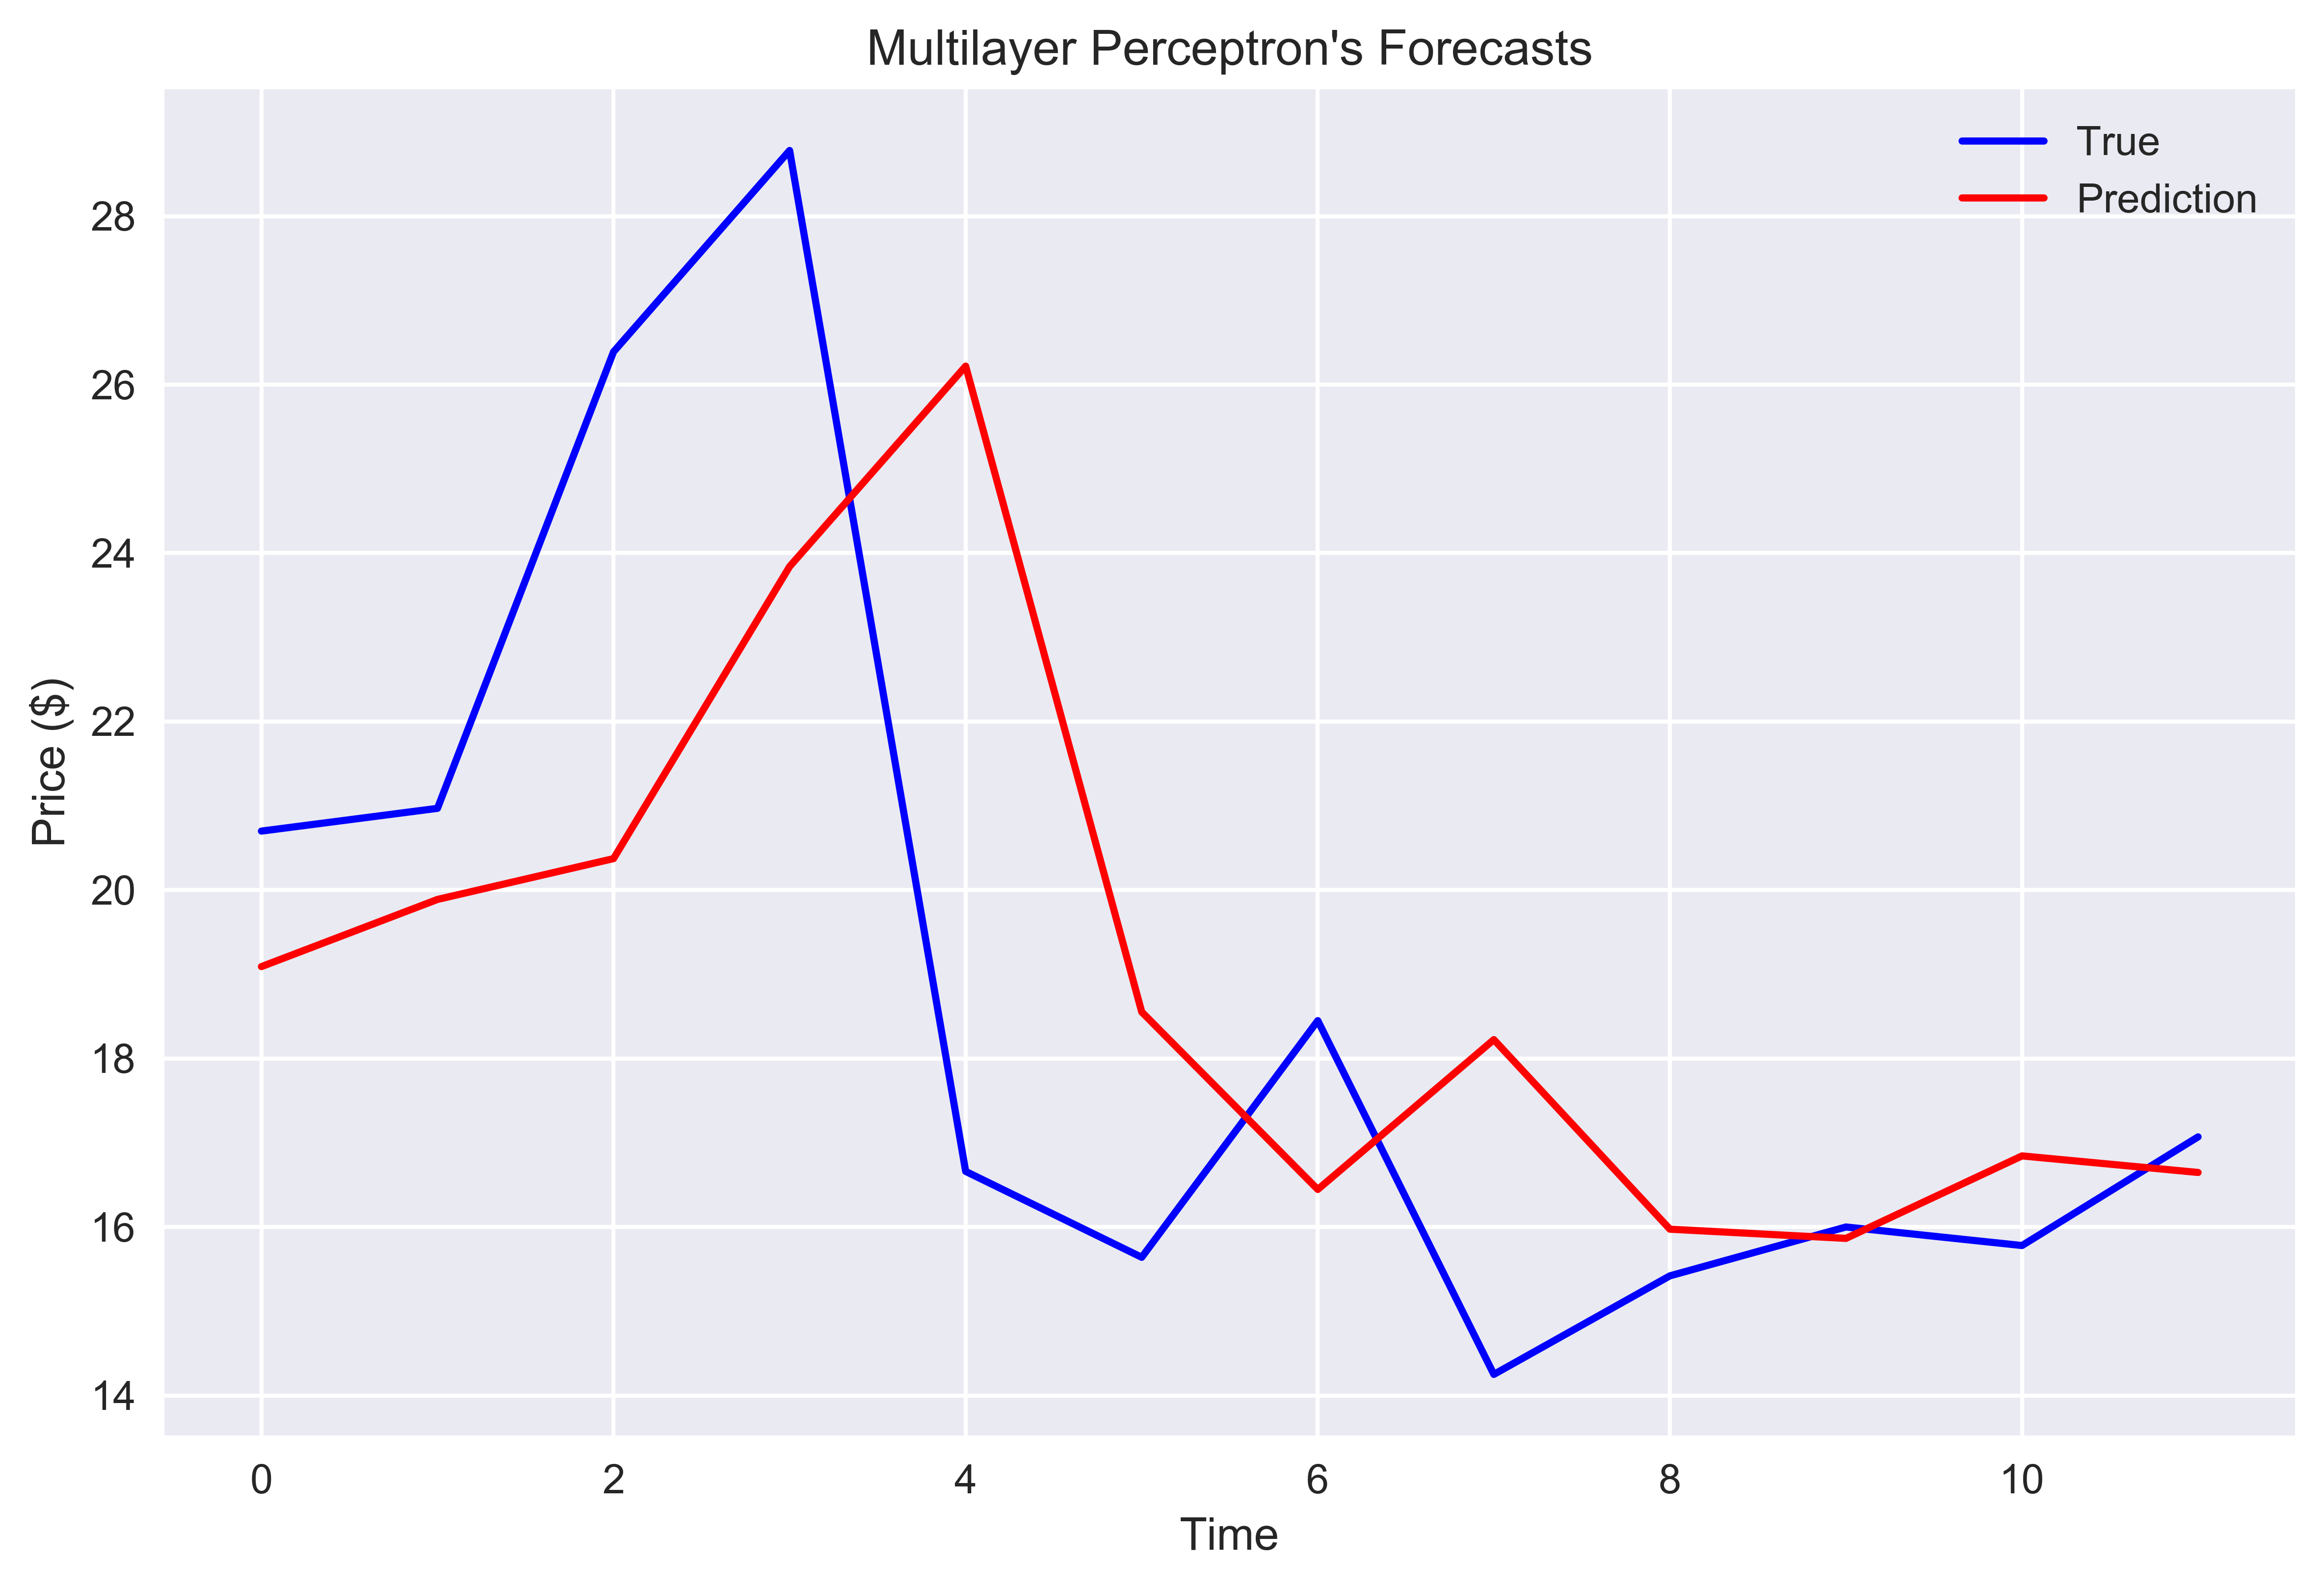

In [23]:
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label= 'True')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="Multilayer Perceptron's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im8.png')
plt.show()

### There's more

#### A sequential approach to defining the network's architecture

Below we define the same network as we have already used before in this recipe:

In [24]:
model = nn.Sequential(
    nn.Linear(3, 8),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 1)
)

model

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=8, out_features=4, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=4, out_features=1, bias=True)
)

#### Estimating neural networks using `scikit-learn`

1. Import the libraries:

In [25]:
from sklearn.neural_network import MLPRegressor

2. Define the MLP using scikit-learn:

In [26]:
mlp = MLPRegressor(hidden_layer_sizes=(8, 4,), 
                   learning_rate='constant',
                   batch_size=5,
                   max_iter=1000,
                   random_state=42)

3. Split the data into training and test set:

In [27]:
valid_ind = len(X) - VALID_SIZE

X_train = X[:valid_ind, ]
y_train = y[:valid_ind]

X_valid = X[valid_ind:, ]
y_valid = y[valid_ind:]

4. Train the MLP:

In [28]:
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size=5, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(8, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

5. Plot the loss function over epochs:

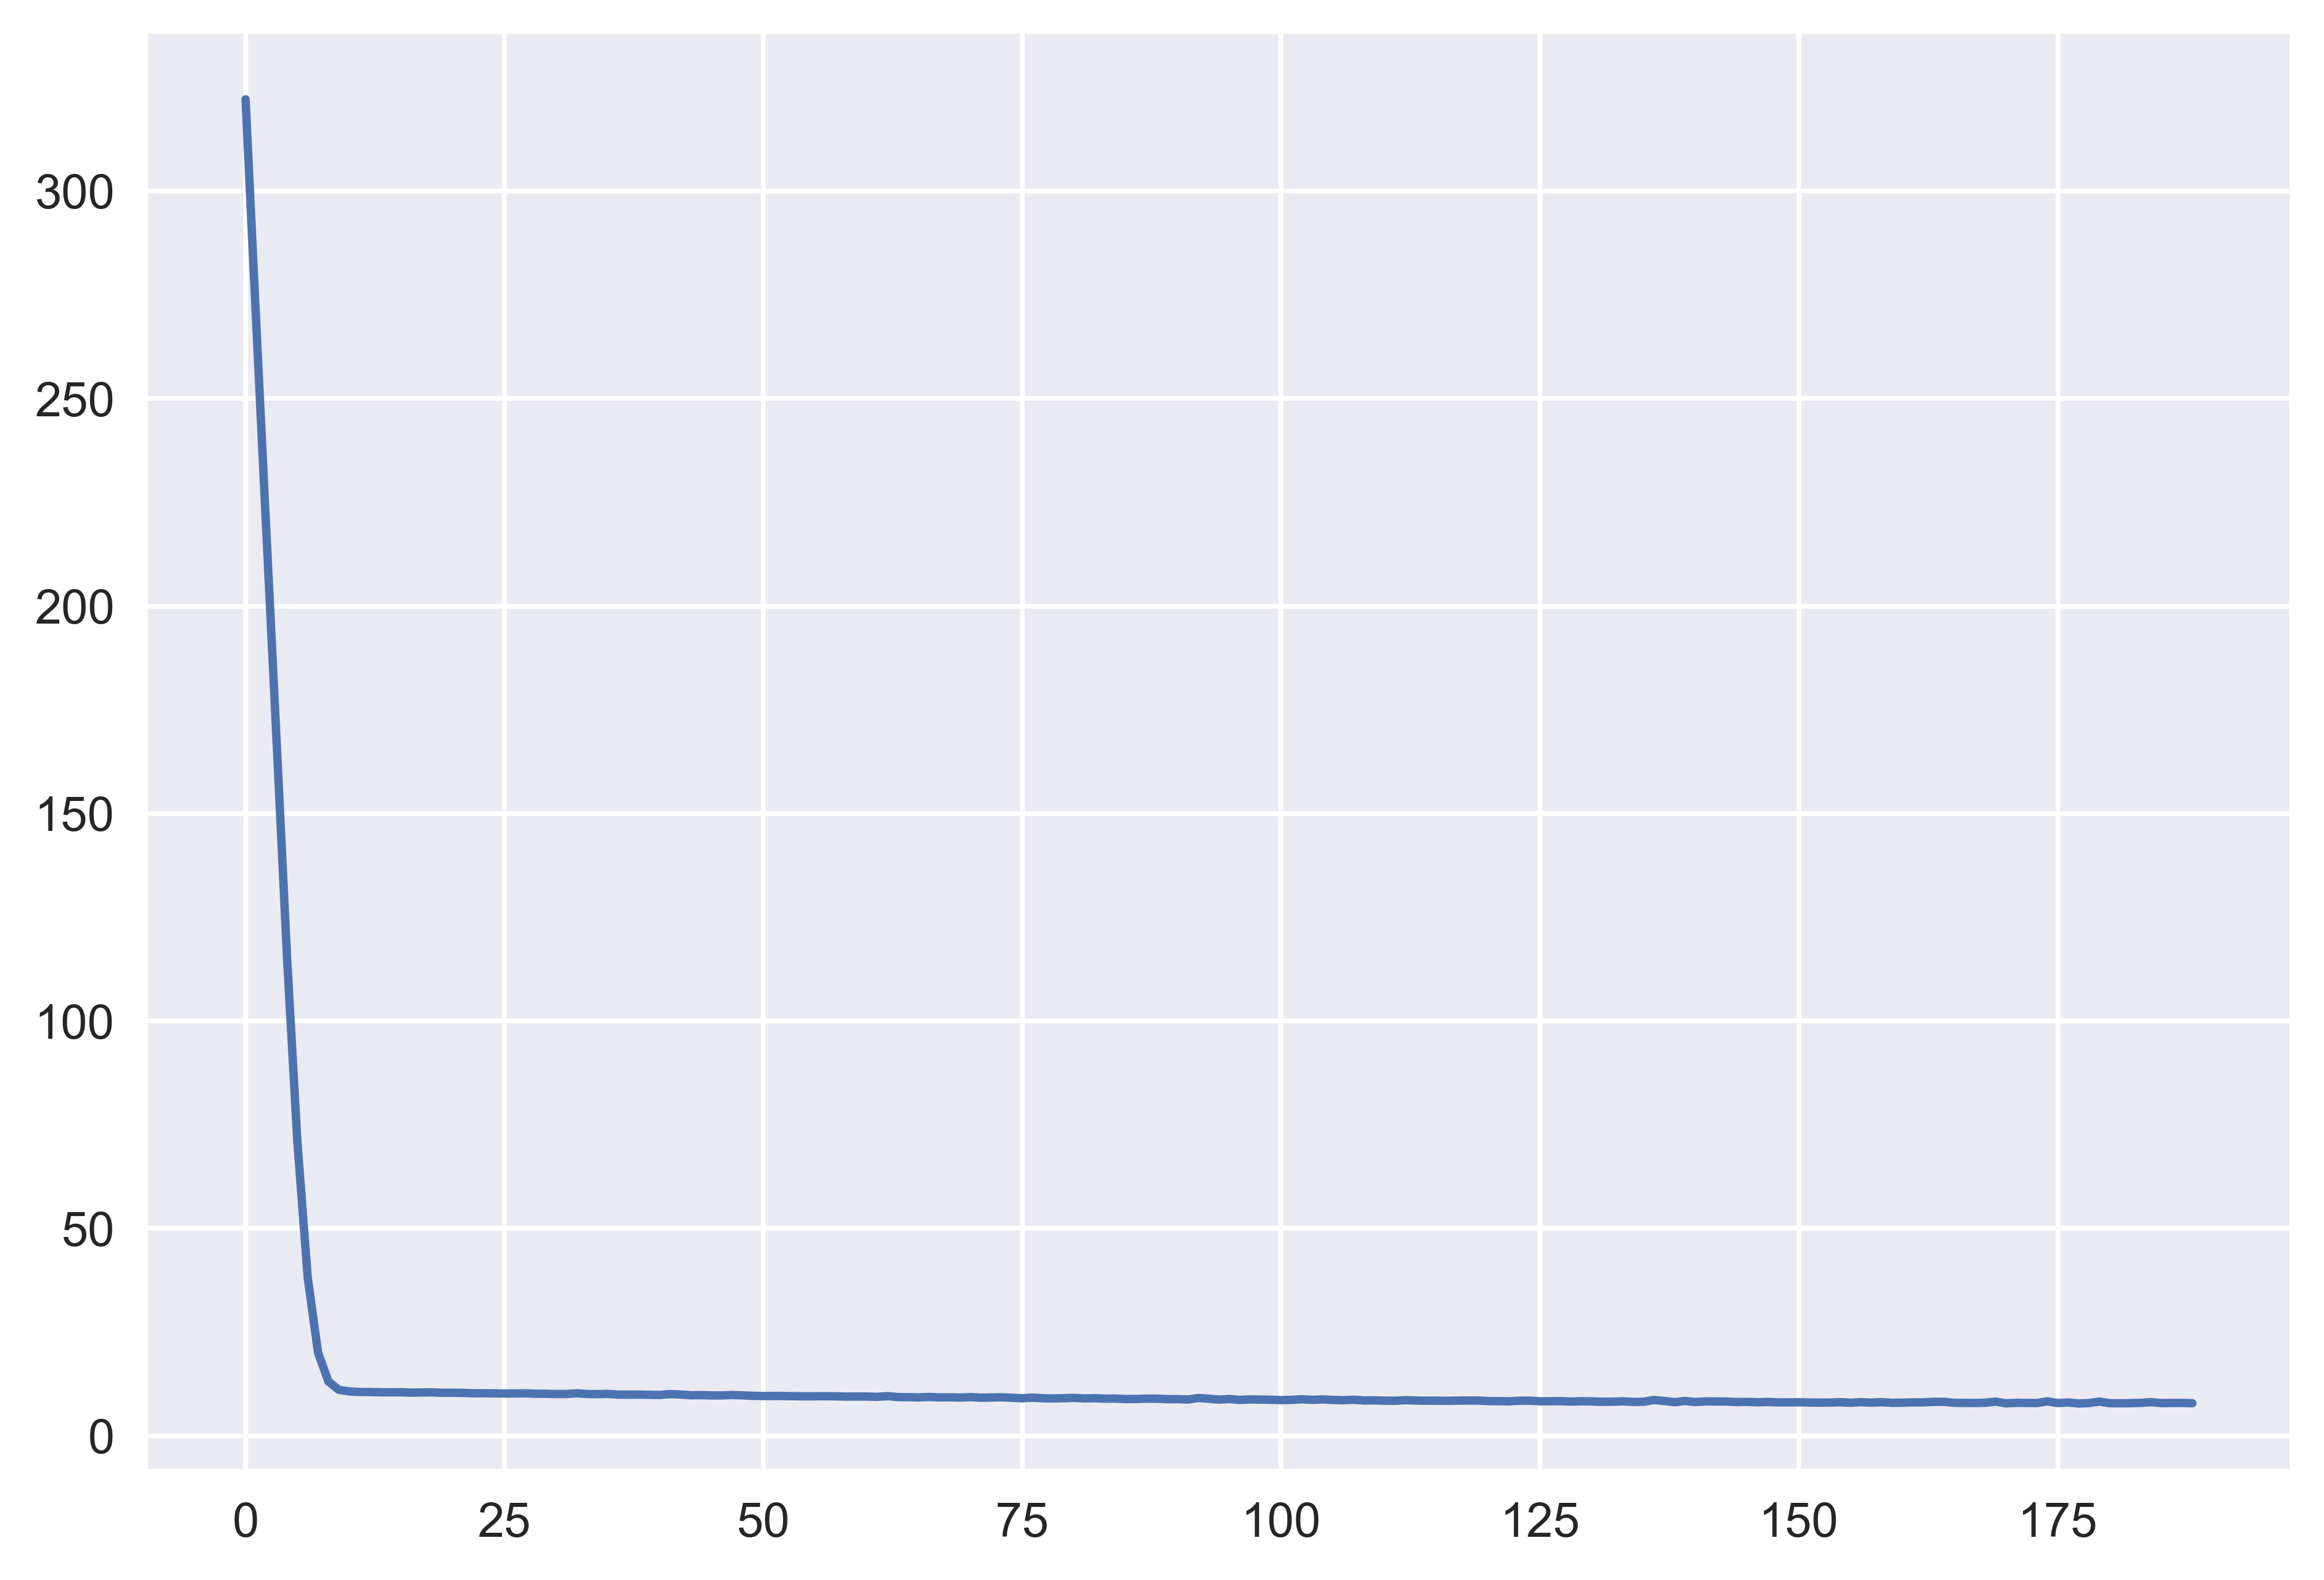

In [29]:
plt.plot(mlp.loss_curve_)

6. Obtain the predictions:

In [30]:
y_pred = mlp.predict(X_valid)

7. Evaluate the predictions and plot them versus the observed values:

Scikit-Learn MLP's forecast - MSE: 17.47, RMSE: 4.18


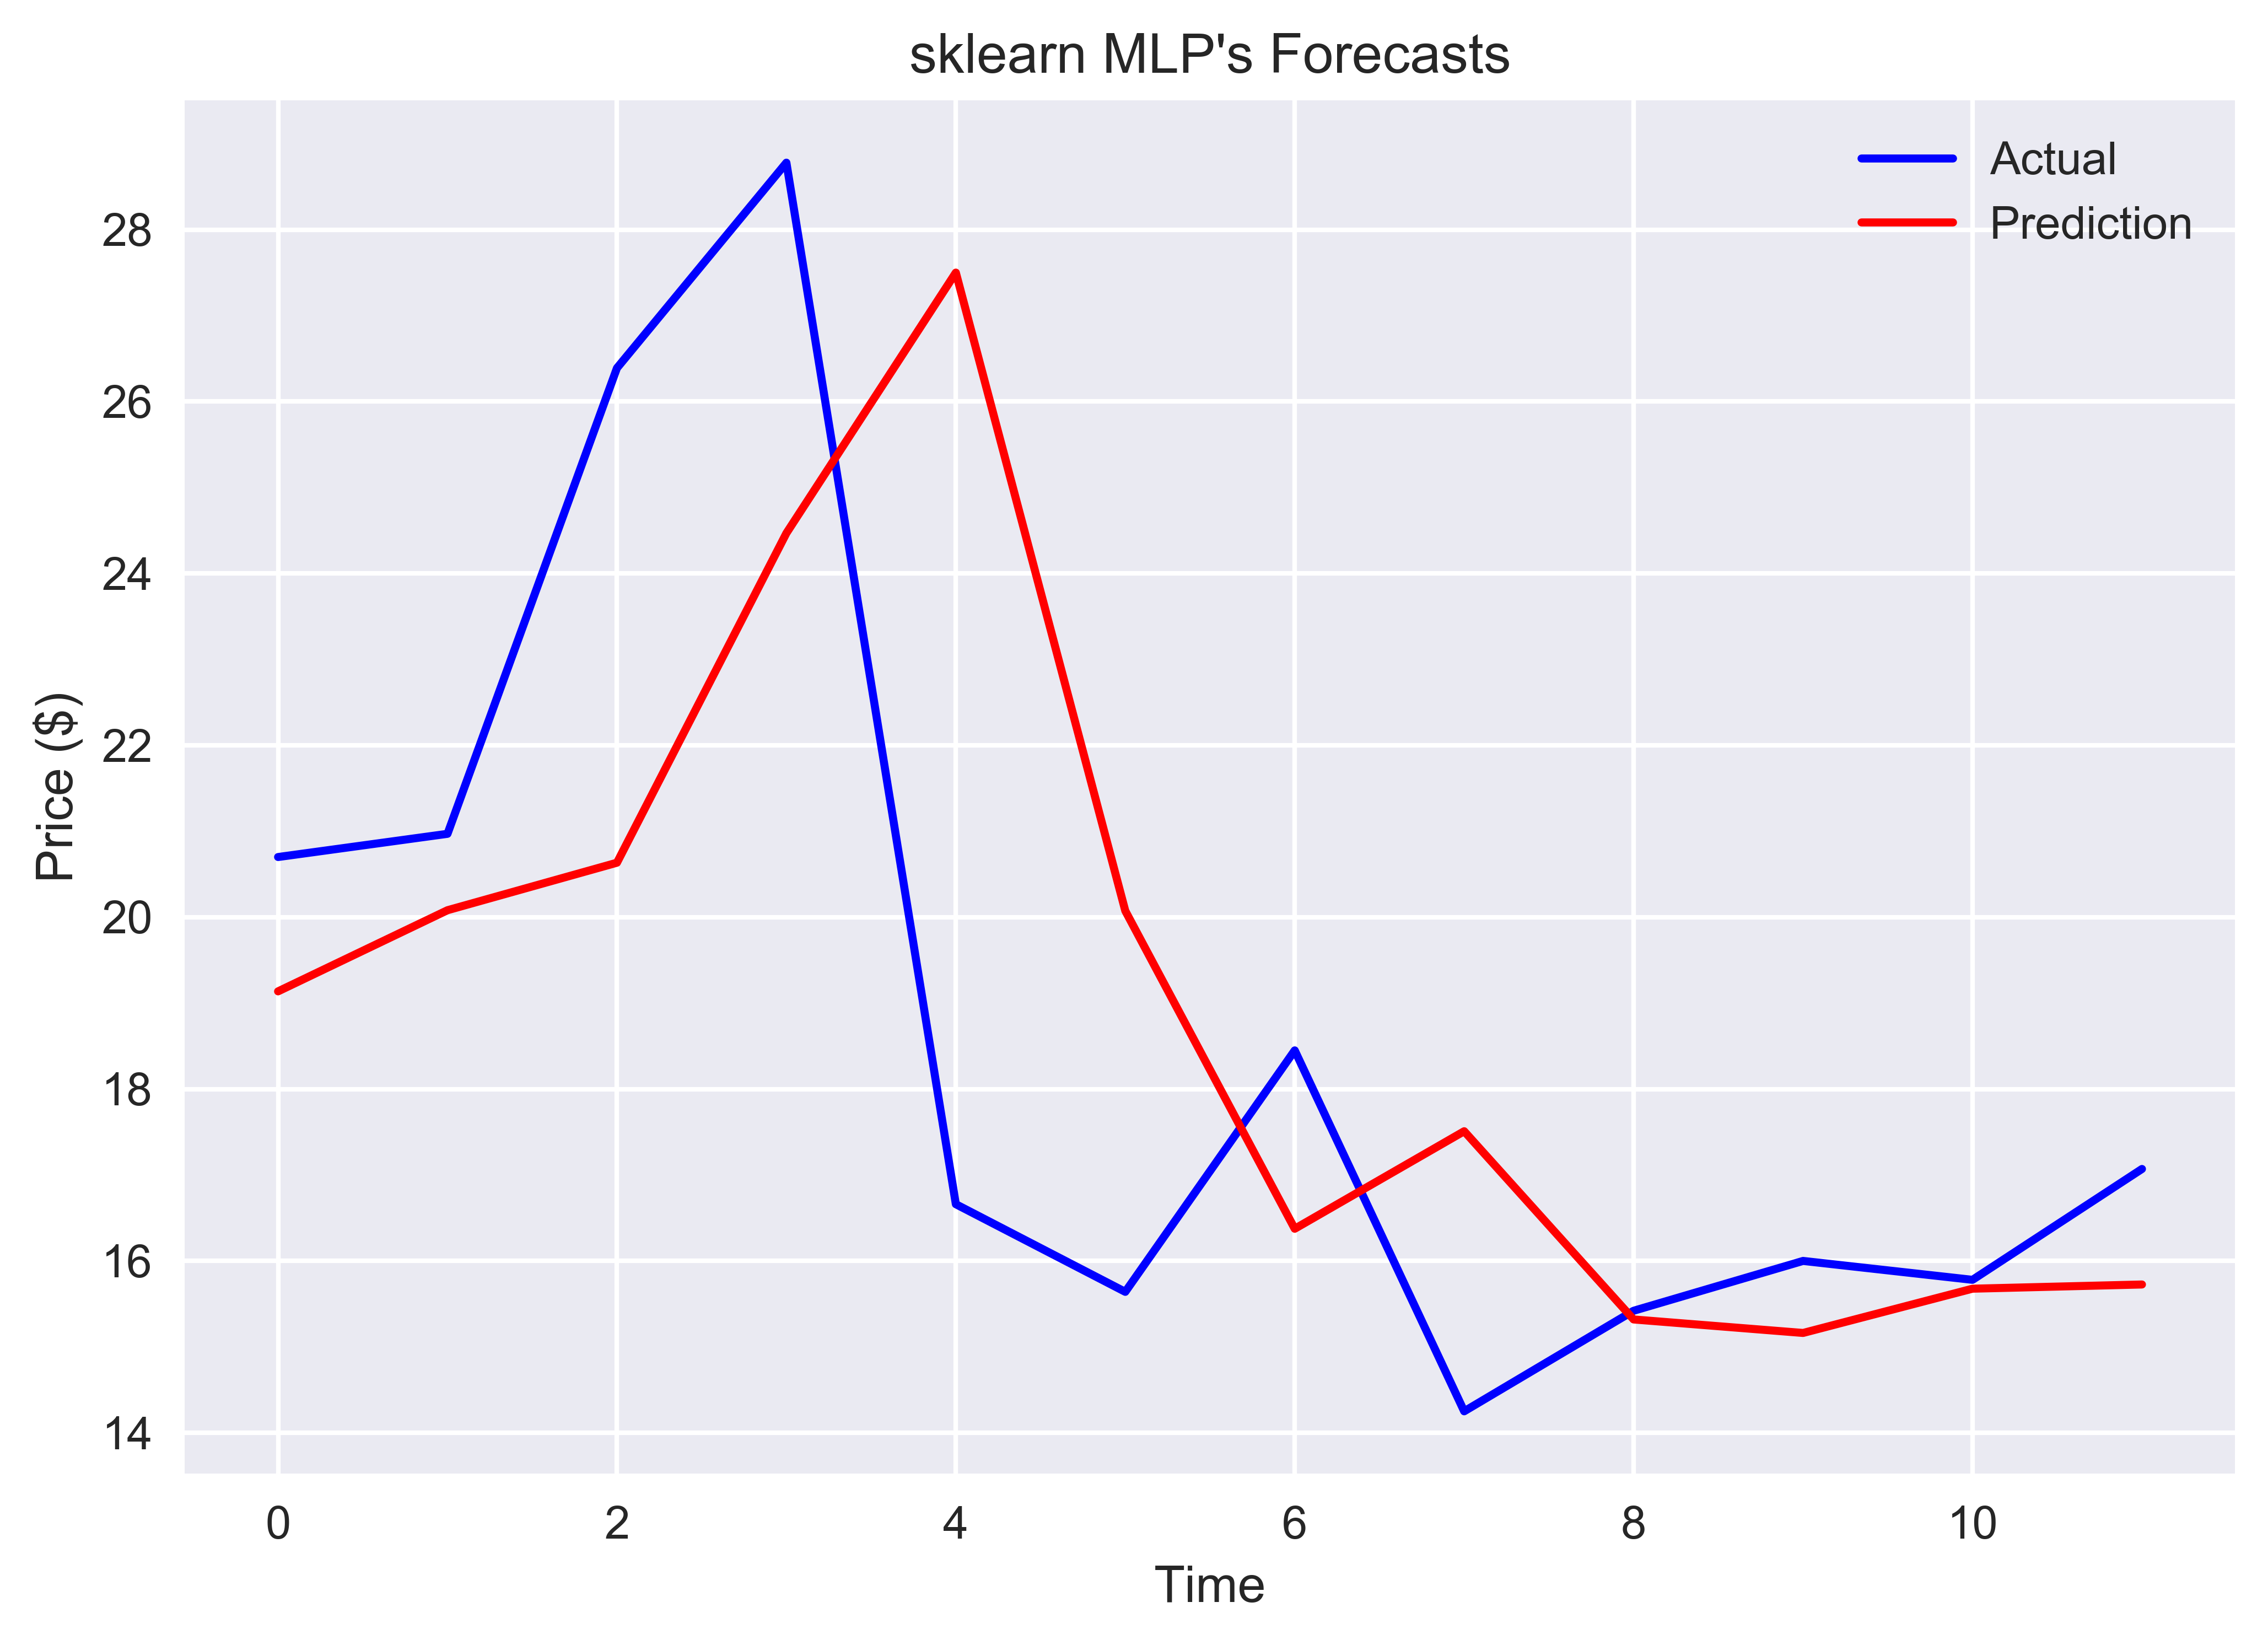

In [31]:
sk_mlp_mse = mean_squared_error(y_valid, y_pred)
sk_mlp_rmse = np.sqrt(sk_mlp_mse)
print(f"Scikit-Learn MLP's forecast - MSE: {sk_mlp_mse:.2f}, RMSE: {sk_mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="sklearn MLP's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend();

#### Multi-period forecast

1. Define a modified function for creating a dataset for the MLP:

In [32]:
def create_input_data(series, n_lags=1, n_leads=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features
    n_leads : int
        The number of future periods we want to forecast for
        
    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X, y = [], []

    for step in range(len(series) - n_lags - n_leads + 1):
        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end])
    return np.array(X), np.array(y)

2. Create features and target from the time series of prices:

In [33]:
# parameters for the dataset
N_LAGS = 3
N_FUTURE = 2

X, y = create_input_data(prices, N_LAGS, N_FUTURE)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

3. Create training and validation sets:

In [34]:
dataset = TensorDataset(X_tensor, y_tensor)

valid_ind = len(X) - VALID_SIZE + (N_FUTURE - 1)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

4. Define the MLP for multi-period forecasting:

In [35]:
class MLP(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, output_size)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x  

5. Instantiate the model, the loss function and the optimizer:

In [36]:
# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS, N_FUTURE).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

6. Train the network:

In [37]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint_2.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 1086.98 	 Valid. loss: 435.49
<50> - Train. loss: 127.08 	 Valid. loss: 27.35
<100> - Train. loss: 75.31 	 Valid. loss: 24.26
<150> - Train. loss: 60.67 	 Valid. loss: 22.53
<200> - Train. loss: 96.59 	 Valid. loss: 21.99
<250> - Train. loss: 66.37 	 Valid. loss: 22.08
<300> - Train. loss: 68.90 	 Valid. loss: 22.03
<350> - Train. loss: 67.22 	 Valid. loss: 21.84
<400> - Train. loss: 55.30 	 Valid. loss: 21.89
<450> - Train. loss: 72.47 	 Valid. loss: 21.83
<500> - Train. loss: 59.31 	 Valid. loss: 23.17
<550> - Train. loss: 55.37 	 Valid. loss: 23.32
<600> - Train. loss: 64.63 	 Valid. loss: 23.76
<650> - Train. loss: 62.94 	 Valid. loss: 22.24
<700> - Train. loss: 67.75 	 Valid. loss: 25.15
<750> - Train. loss: 84.69 	 Valid. loss: 26.54
<800> - Train. loss: 84.53 	 Valid. loss: 25.65
<850> - Train. loss: 63.62 	 Valid. loss: 27.78
<900> - Train. loss: 53.08 	 Valid. loss: 26.04
<950> - Train. loss: 53.23 	 Valid. loss: 23.41
Lowest loss recorded in epoch: 360


7. Plot the training and validation losses:

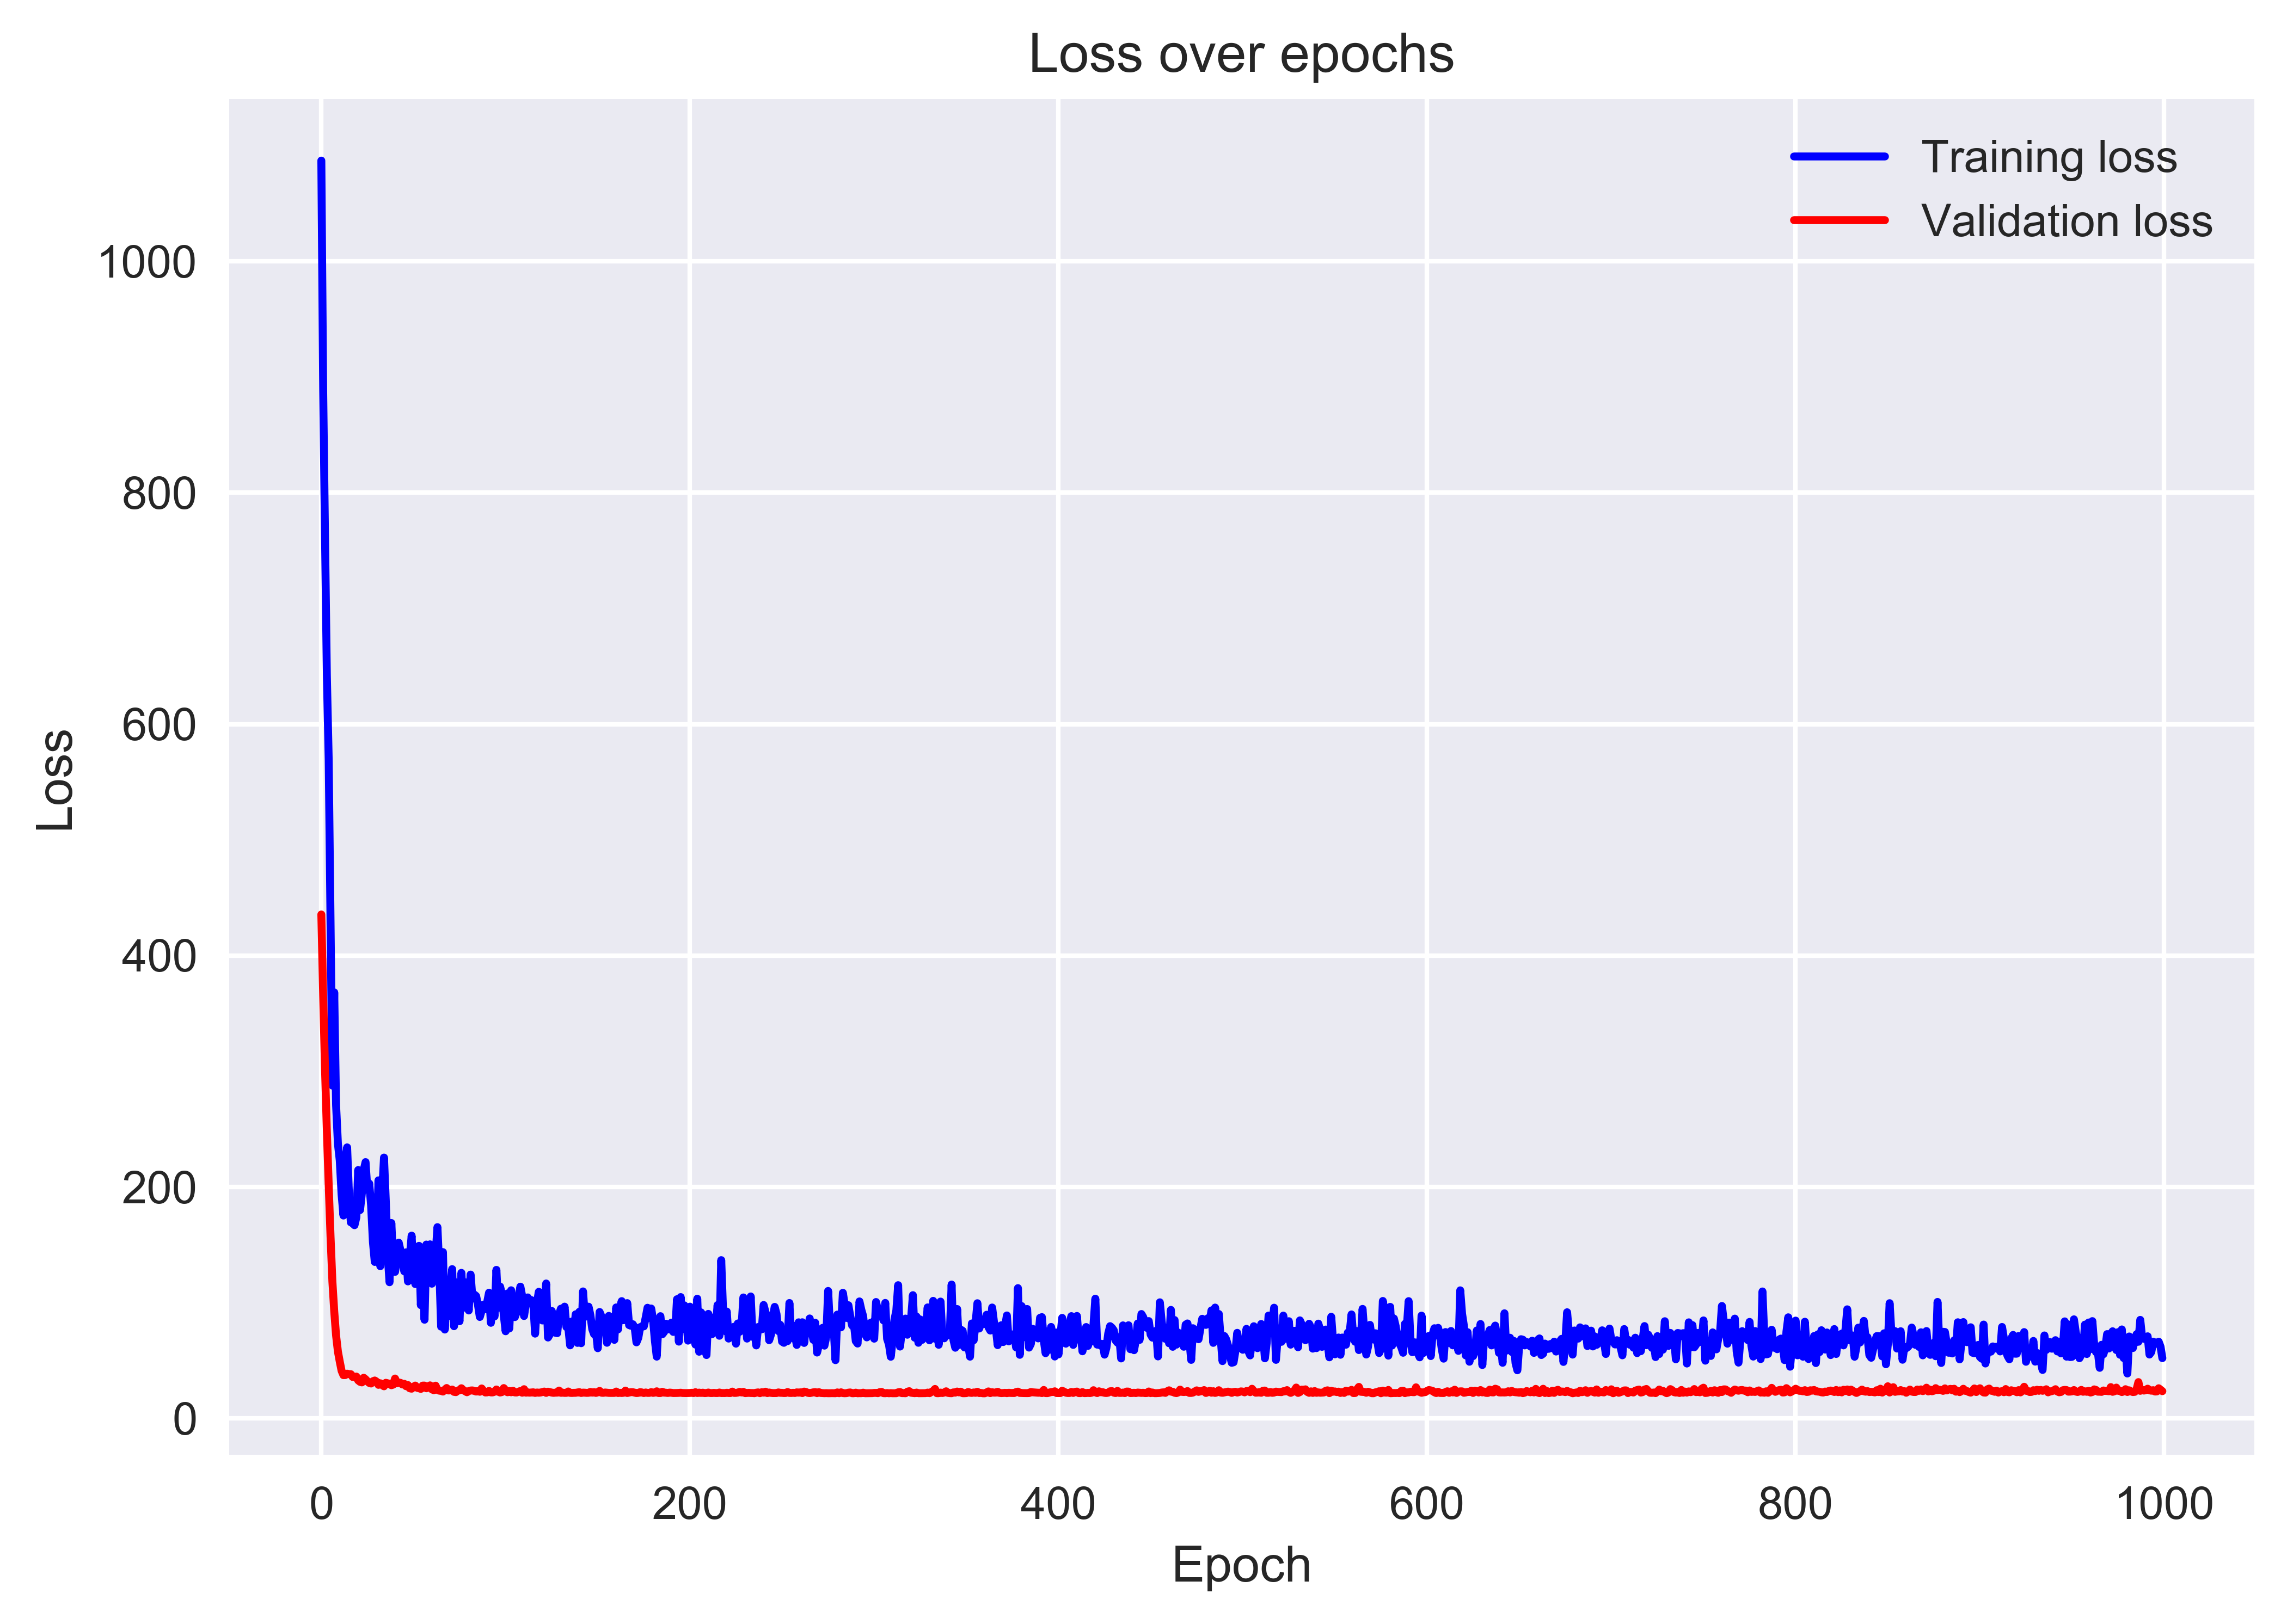

In [39]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend();

8. Load the best model (with the lowest validation loss):

In [40]:
state_dict = torch.load('mlp_checkpoint_2.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

9. Obtain predictions:

In [41]:
y_pred = []

with torch.no_grad():
    
    model.eval()
        
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        yhat = model(x_val)
        y_pred.append(yhat)
               
y_pred = torch.cat(y_pred).numpy()

10. Plot the predictions:

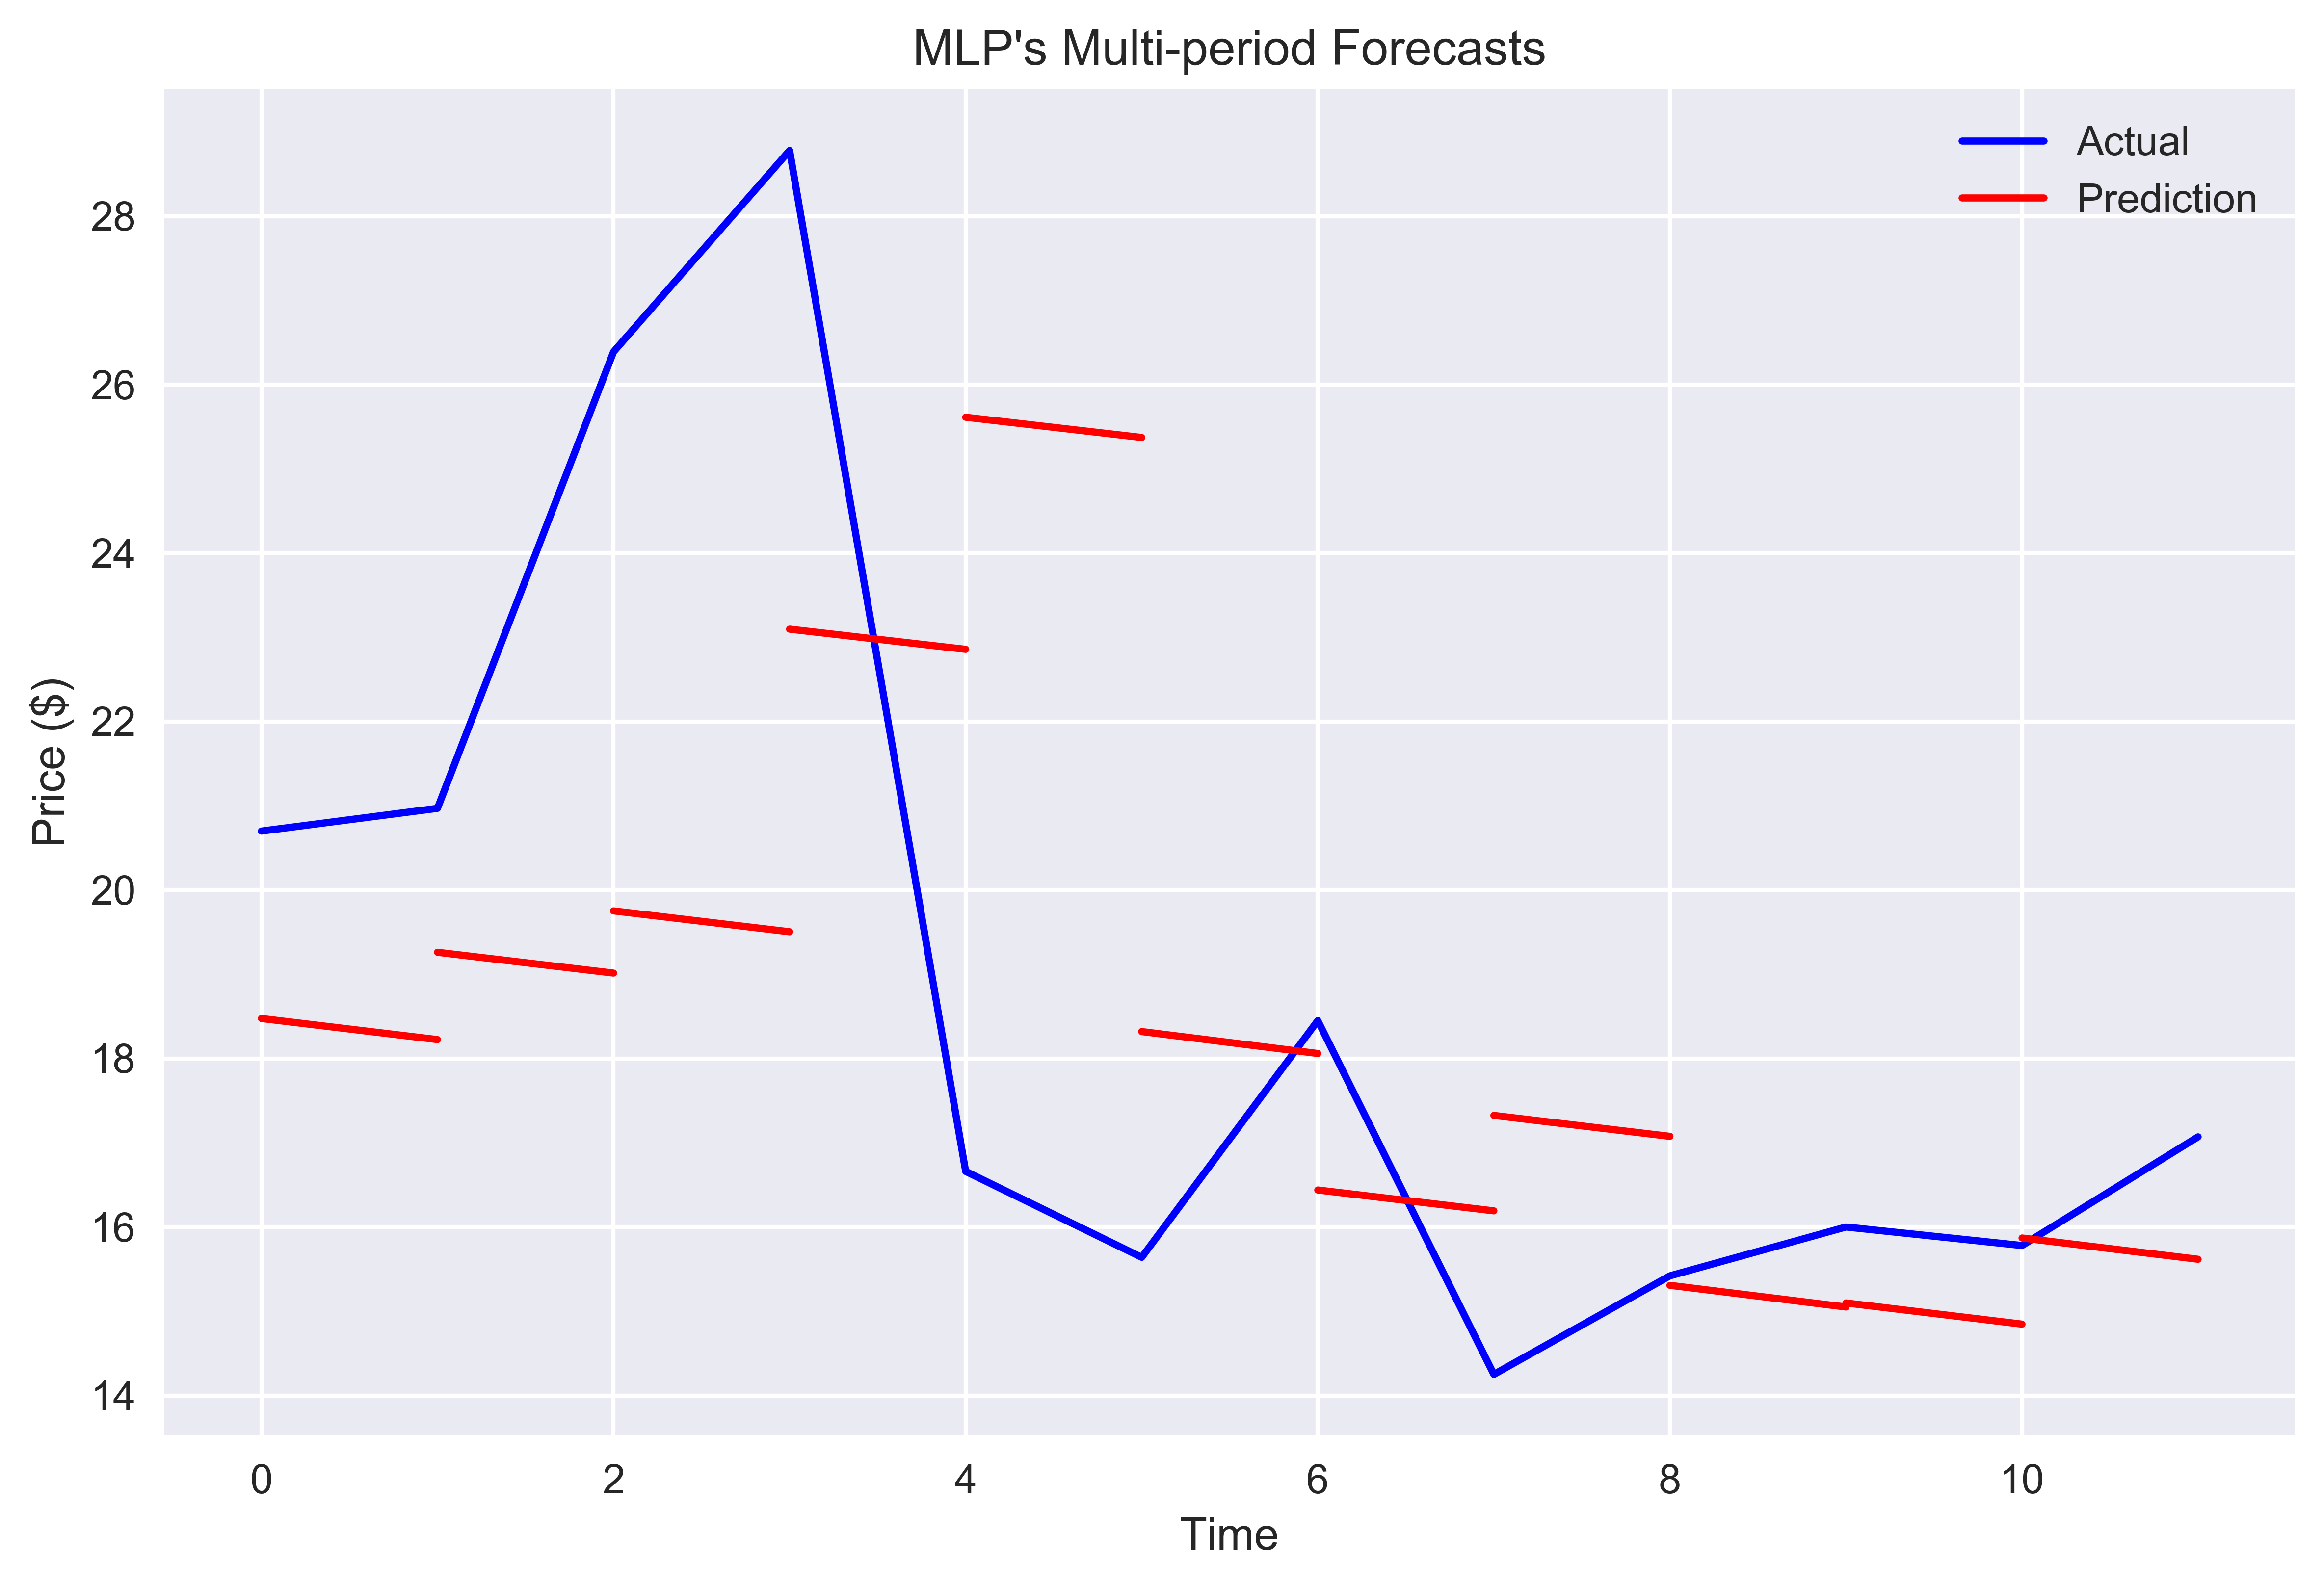

In [42]:
fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')

for i in range(len(y_pred)):
    if i == 0:
        ax.plot(np.array([i, i + 1]), y_pred[i], color='red', label='Prediction')
    else:
        ax.plot(np.array([i, i + 1]), y_pred[i], color='red')

ax.set(title="MLP's Multi-period Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im9.png')
plt.show()

## Convolutional neural networks for time series forecasting

### How to do it...

1. Import the libraries:

In [5]:
import yfinance as yf
import numpy as np
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.3.1


2. Define the parameters:

In [6]:
# data
TICKER = 'INTL'
START_DATE = '2015-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 5
N_EPOCHS = 2000

3. Download and prepare the data:

In [7]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values

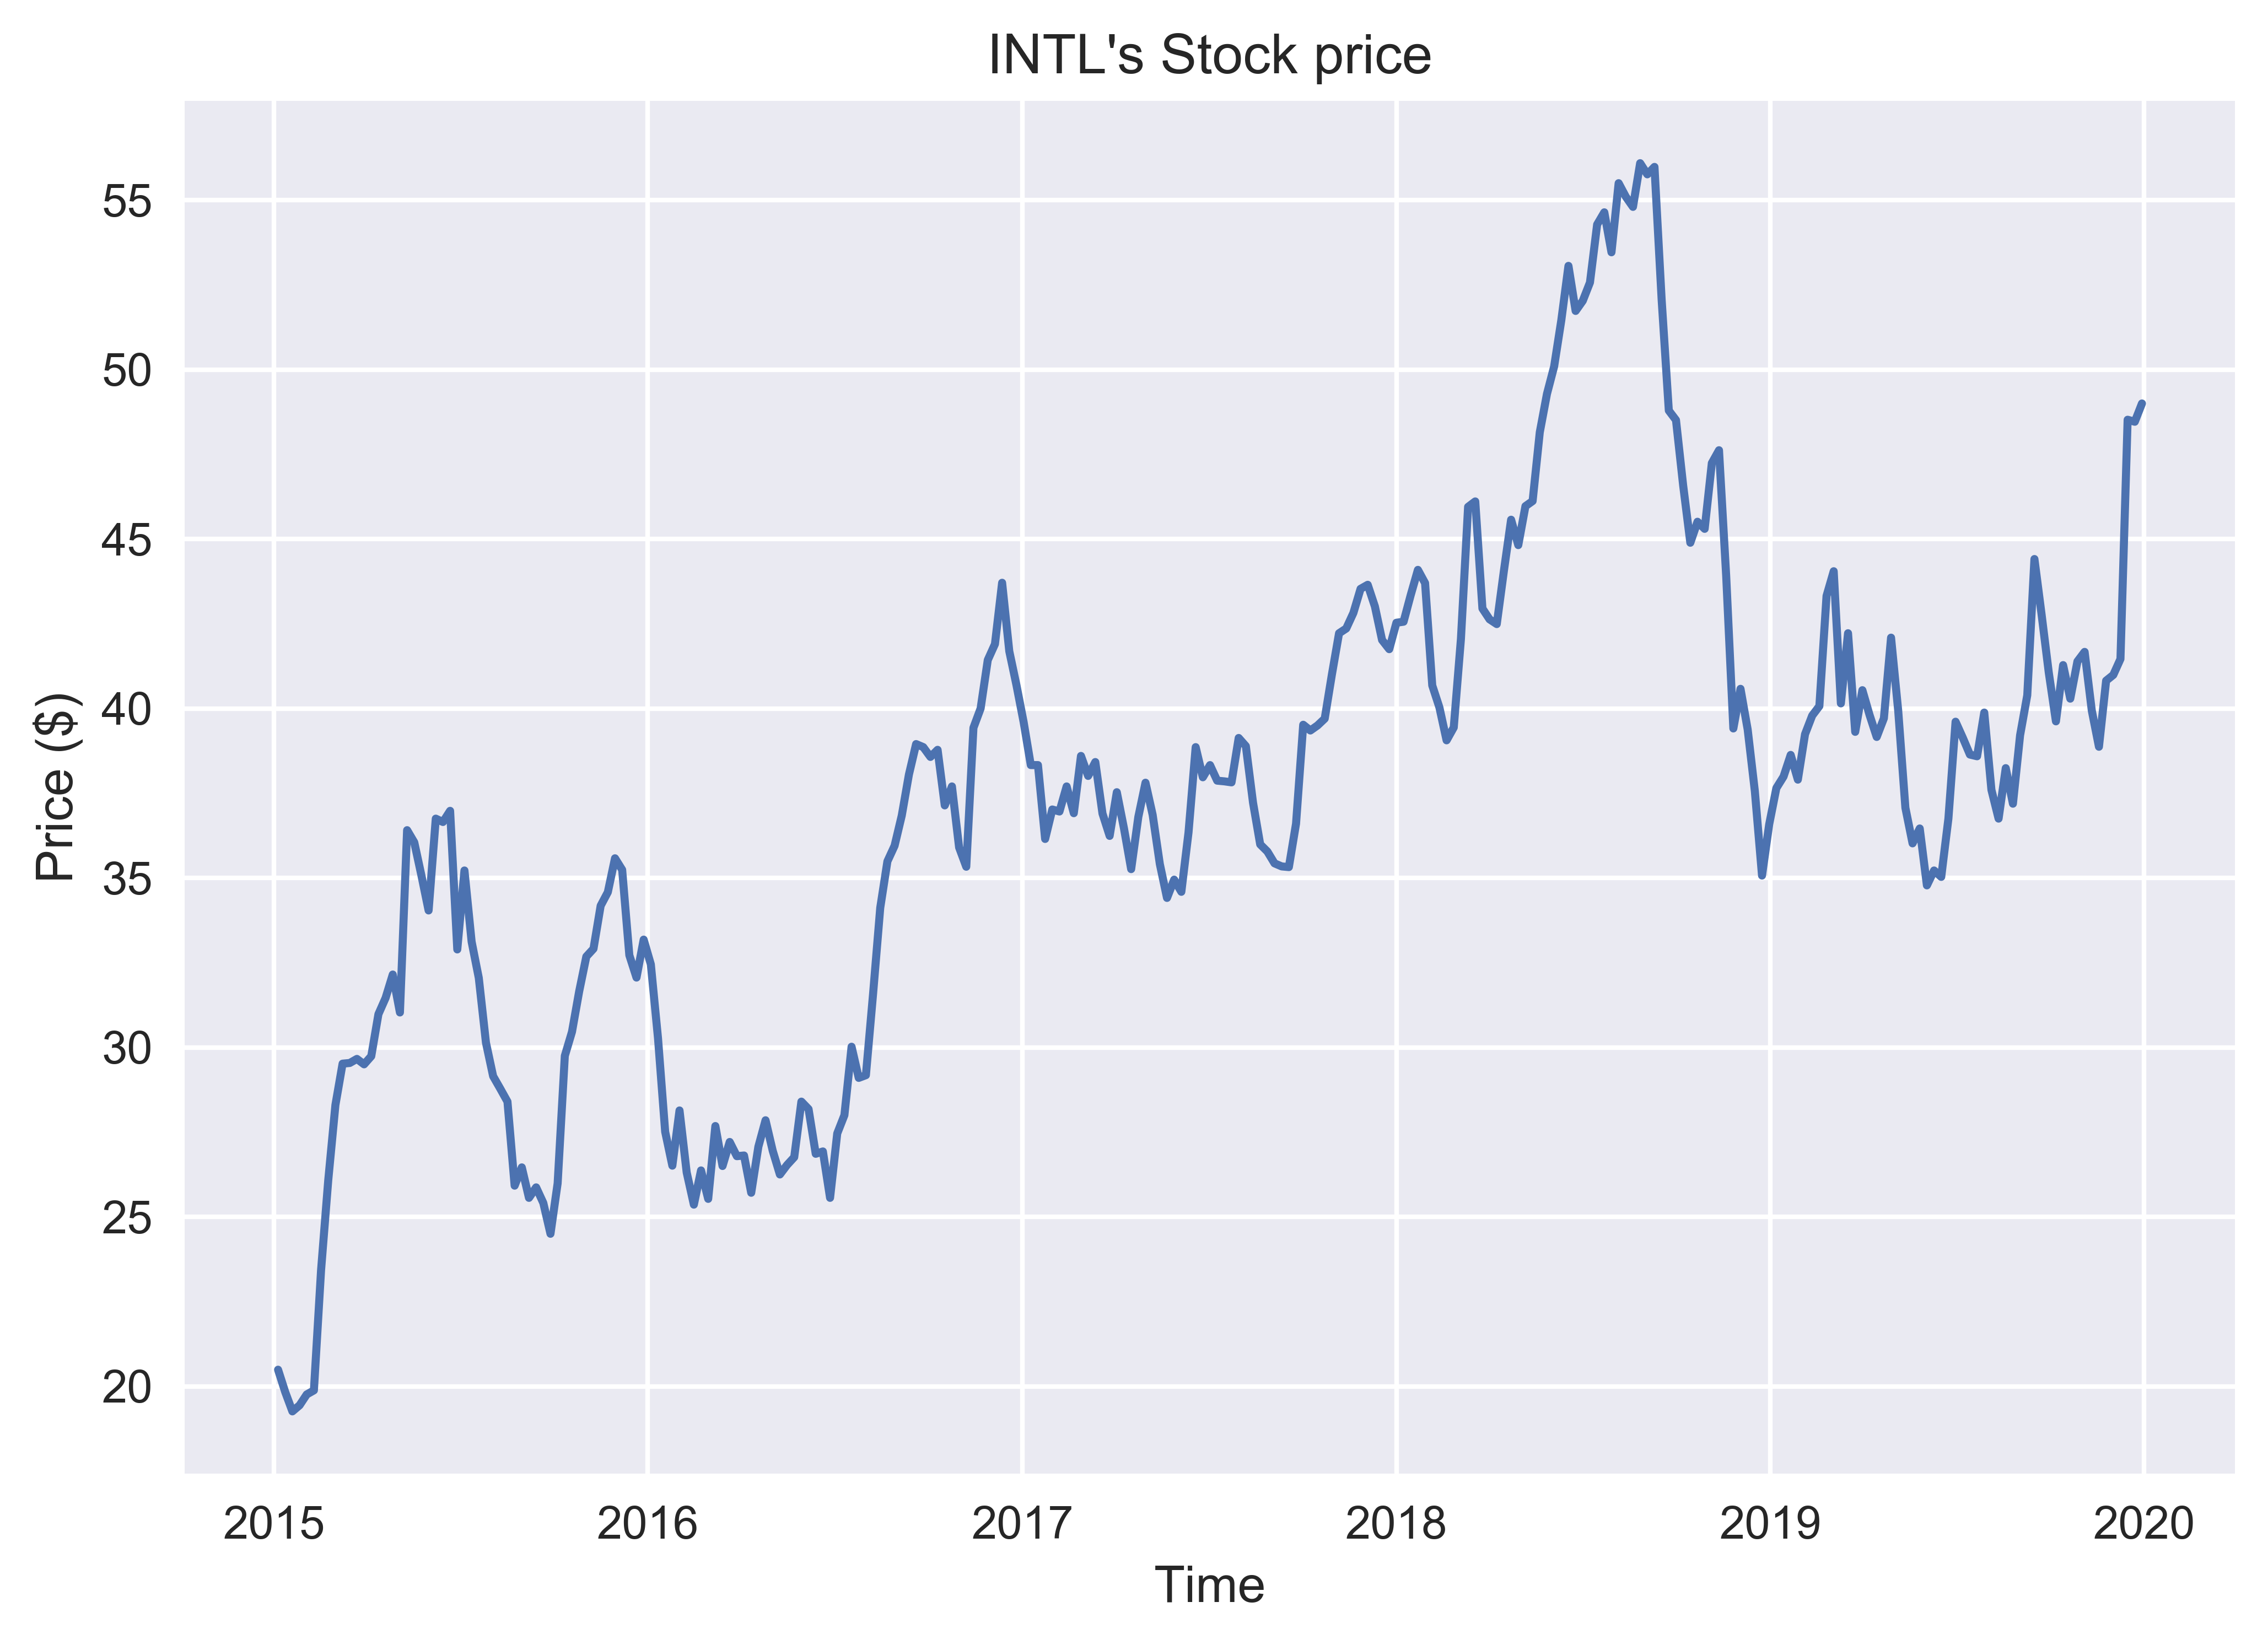

In [6]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Transform the time series into input for the CNN:

In [7]:
X, y = create_input_data(prices, N_LAGS)

5. Obtain the naïve forecast:

In [8]:
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 4.16, RMSE: 2.04


6. Prepare the `DataLoader` objects:

In [9]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Check the size of the datasets:

In [10]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 222 | validation: 27


7. Define the CNN's architecture:

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


8. Instantiate the model, the loss function and the optimizer:

In [12]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

9. Train the network:

In [13]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './cnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 11.353606 	 Valid. loss: 2.795806
<50> - Train. loss: 7.221739 	 Valid. loss: 5.951306
<100> - Train. loss: 7.291781 	 Valid. loss: 2.114502
<150> - Train. loss: 6.709144 	 Valid. loss: 1.902876
<200> - Train. loss: 6.602802 	 Valid. loss: 3.754762
<250> - Train. loss: 6.807027 	 Valid. loss: 1.926065
<300> - Train. loss: 6.209598 	 Valid. loss: 2.000837
<350> - Train. loss: 6.140596 	 Valid. loss: 1.778180
<400> - Train. loss: 5.752879 	 Valid. loss: 2.819091
<450> - Train. loss: 5.893142 	 Valid. loss: 2.042736
<500> - Train. loss: 5.587675 	 Valid. loss: 1.894687
<550> - Train. loss: 5.671599 	 Valid. loss: 1.831246
<600> - Train. loss: 5.470355 	 Valid. loss: 2.080399
<650> - Train. loss: 5.644035 	 Valid. loss: 2.210566
<700> - Train. loss: 5.598150 	 Valid. loss: 2.177404
<750> - Train. loss: 5.135477 	 Valid. loss: 2.334644
<800> - Train. loss: 5.360616 	 Valid. loss: 2.257405
<850> - Train. loss: 4.994429 	 Valid. loss: 1.861241
<900> - Train. loss: 4.299214 

10. Plot the losses over epochs:

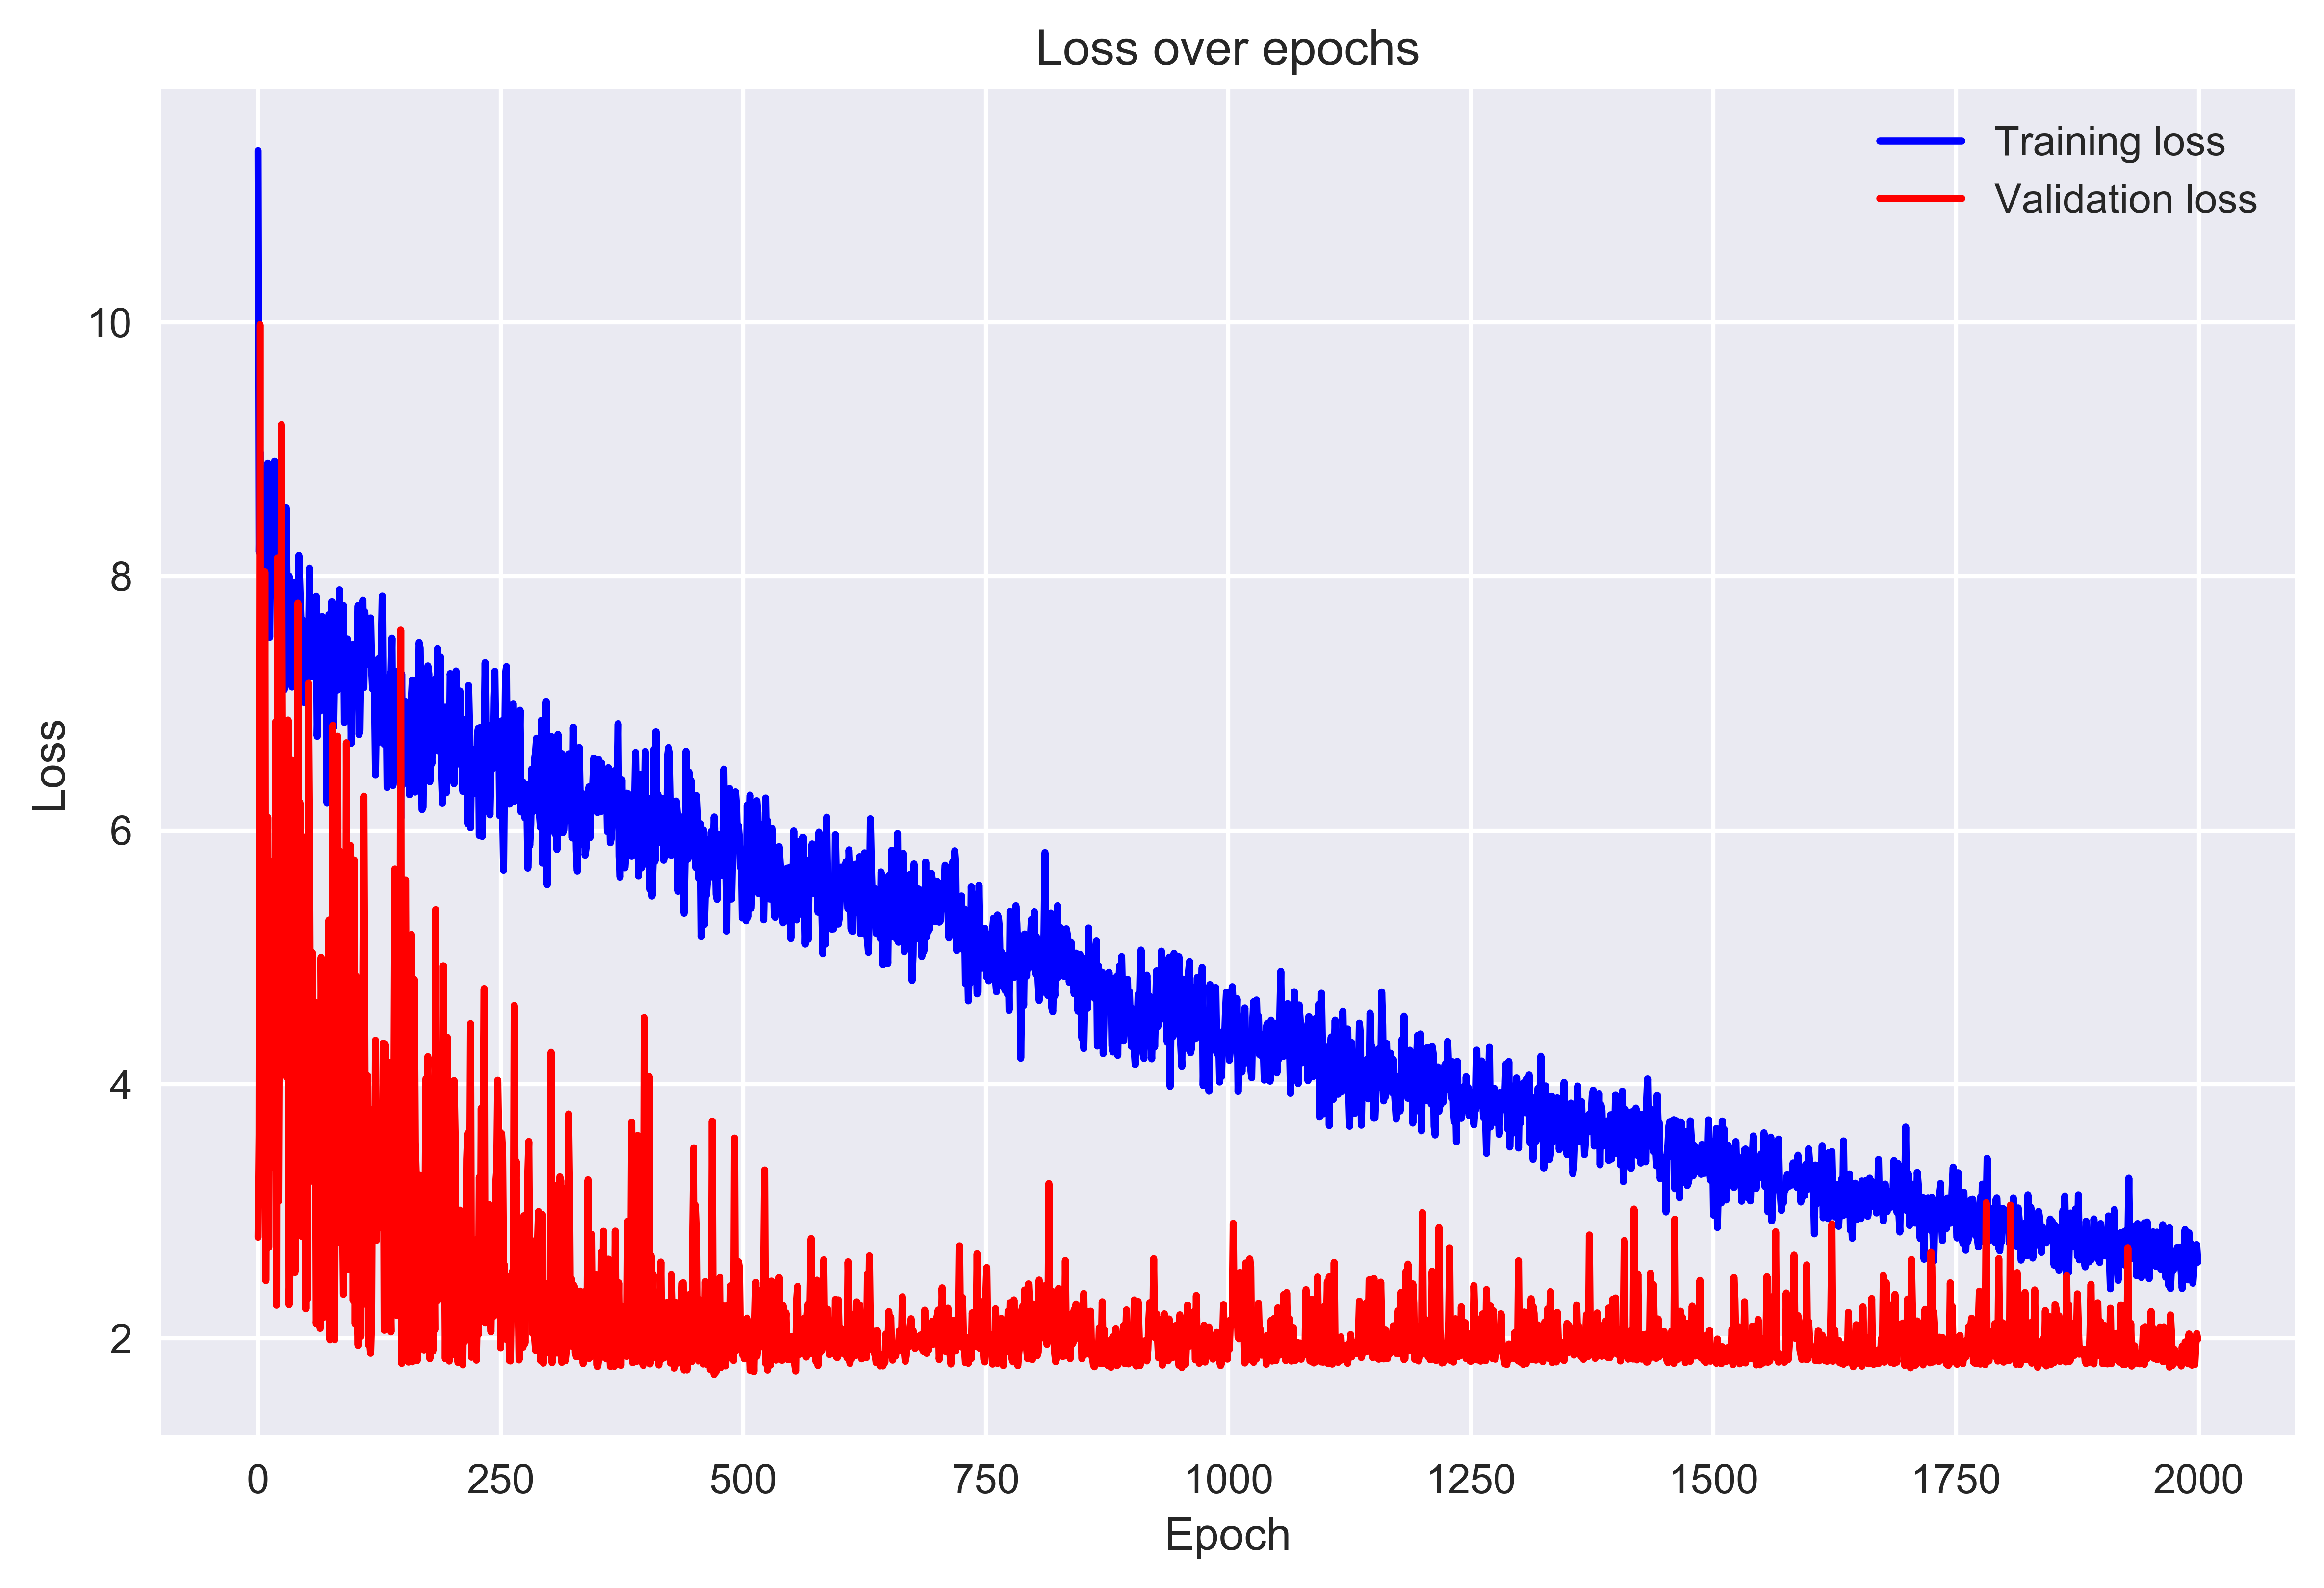

In [14]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im11.png')
plt.show()

11. Load the best model (with the lowest validation loss):

In [15]:
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

12. Obtain the predictions:

In [16]:
y_pred, y_valid = [], []

with torch.no_grad():
    
    model.eval()
        
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

13. Evaluate the predictions:

CNN's forecast - MSE: 3.58, RMSE: 1.89


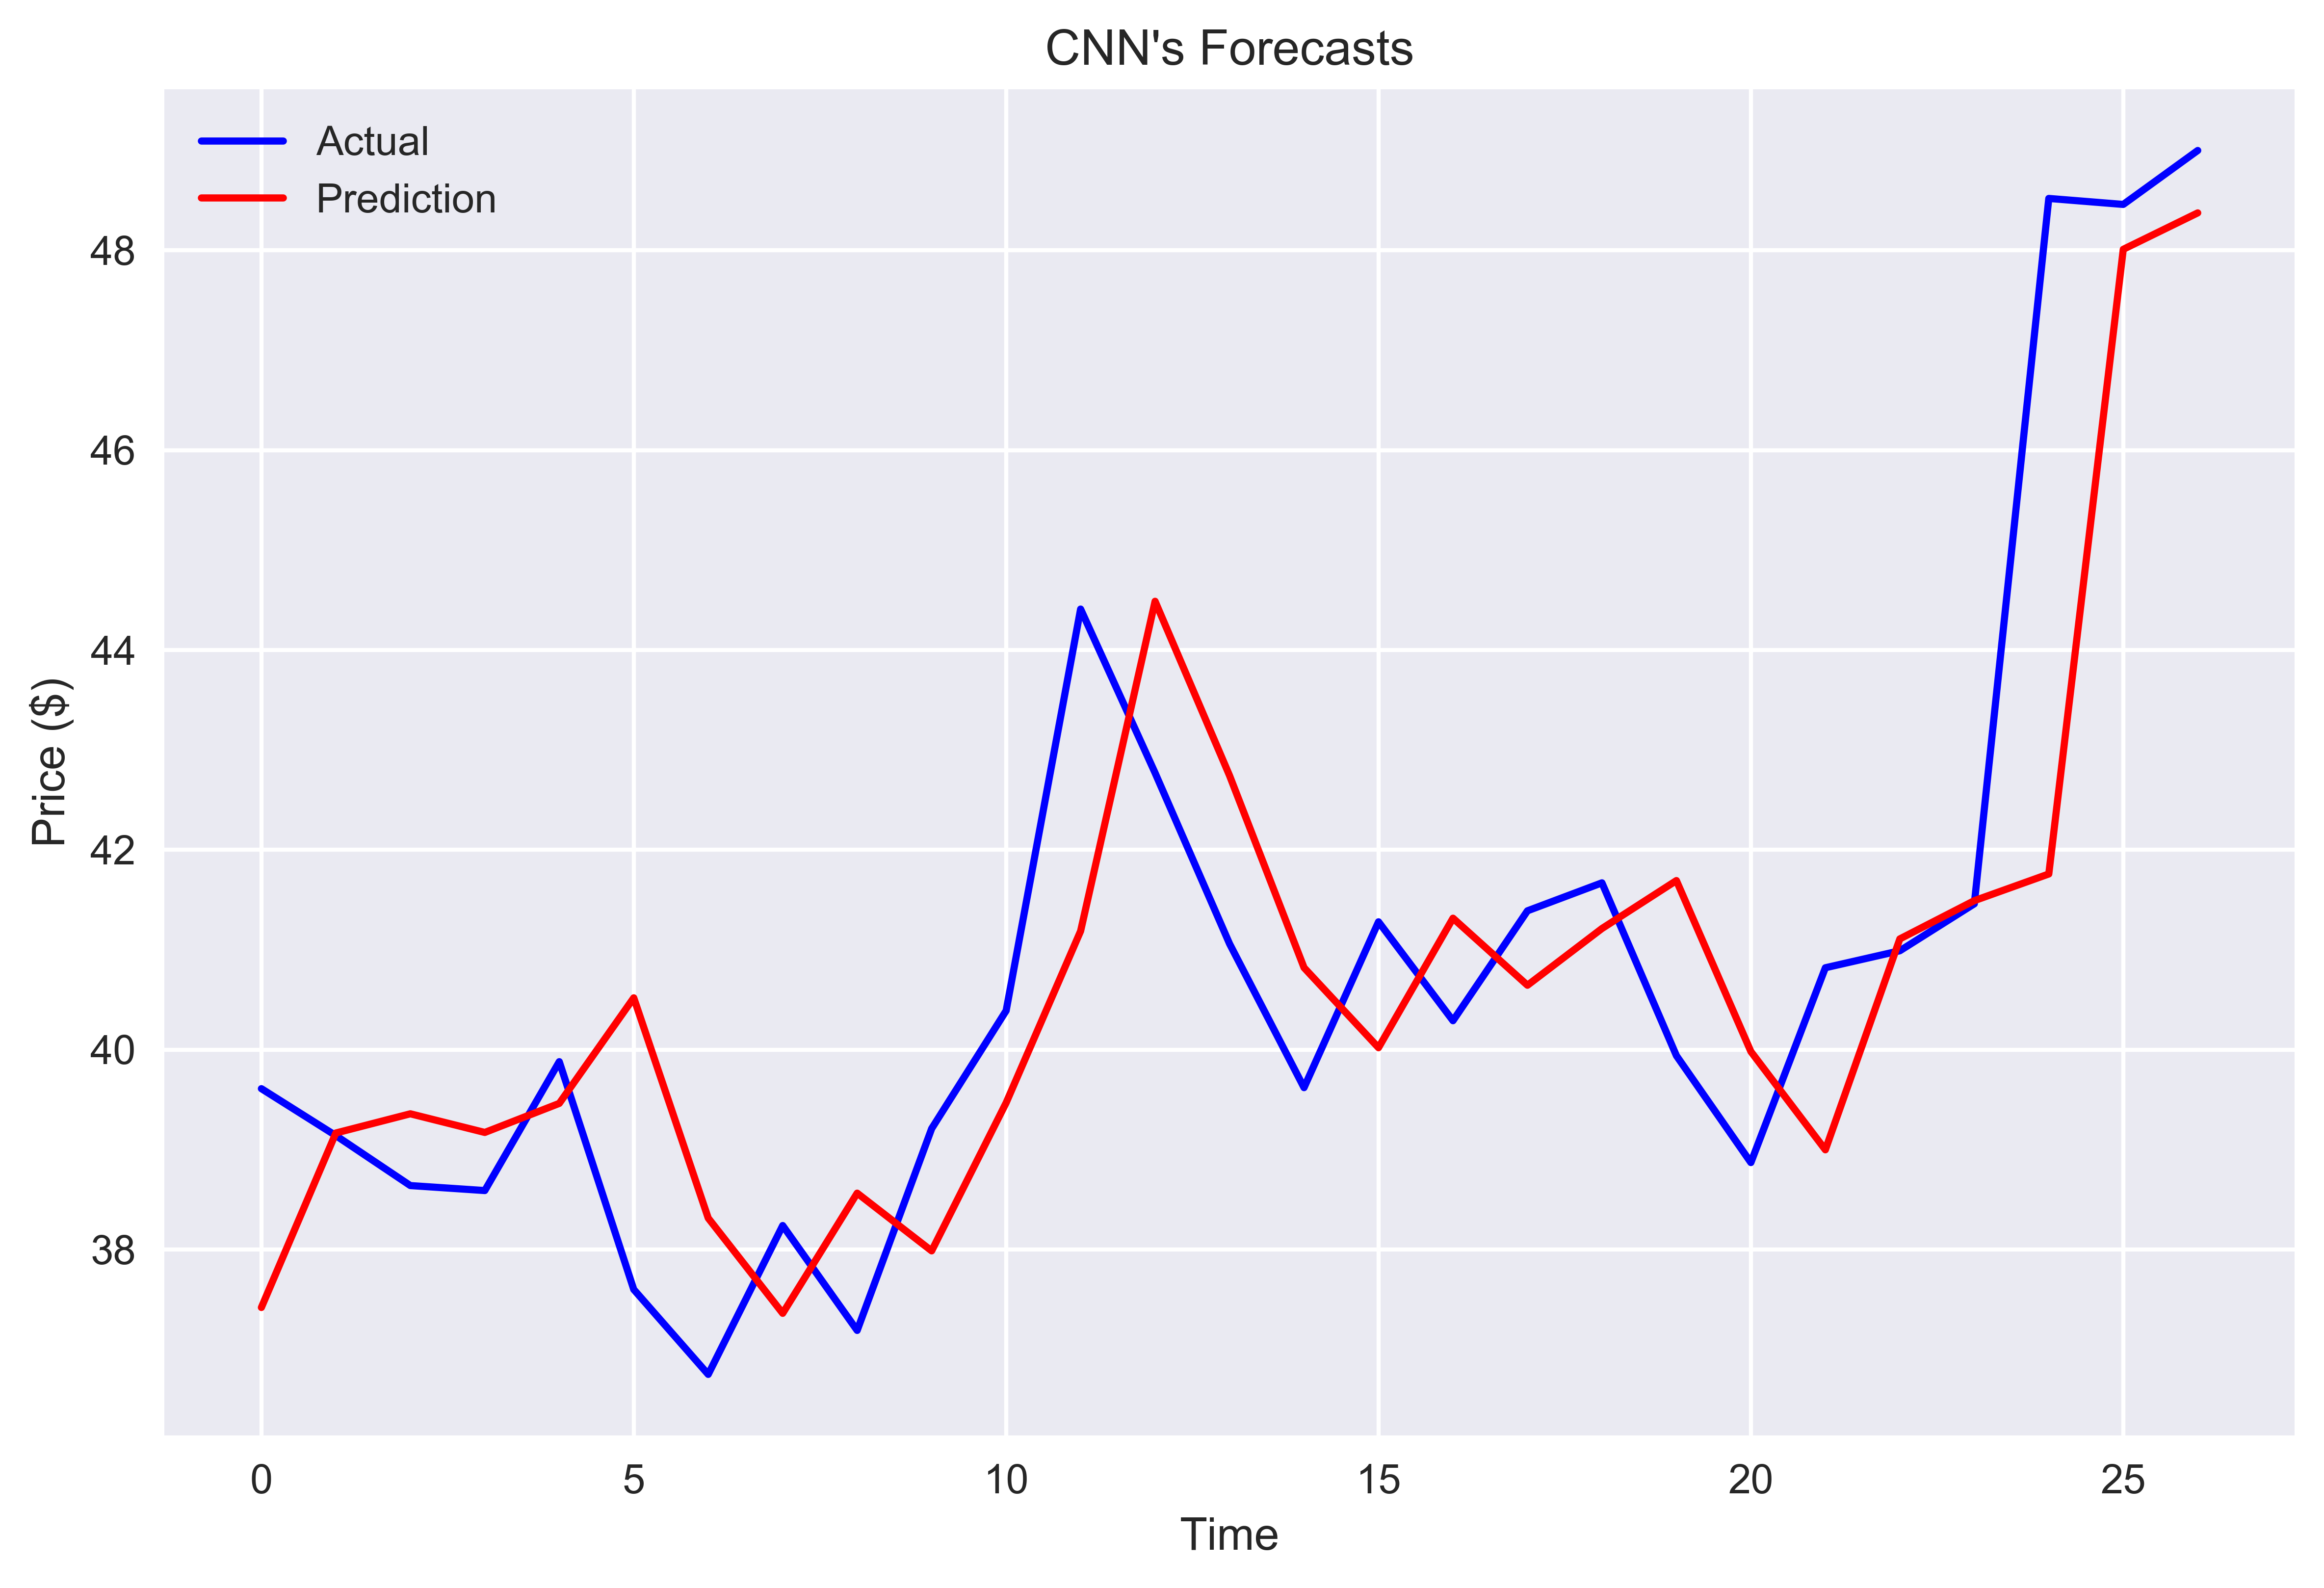

In [17]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')
#ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="CNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im12.png')
plt.show()

## Recurrent neural networks for time series forecasting

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.3.1


2. Define the parameters:

In [4]:
# data
TICKER = 'INTL'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 16
N_EPOCHS = 100

3. Download and prepare the data:

In [5]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values.reshape(-1, 1)

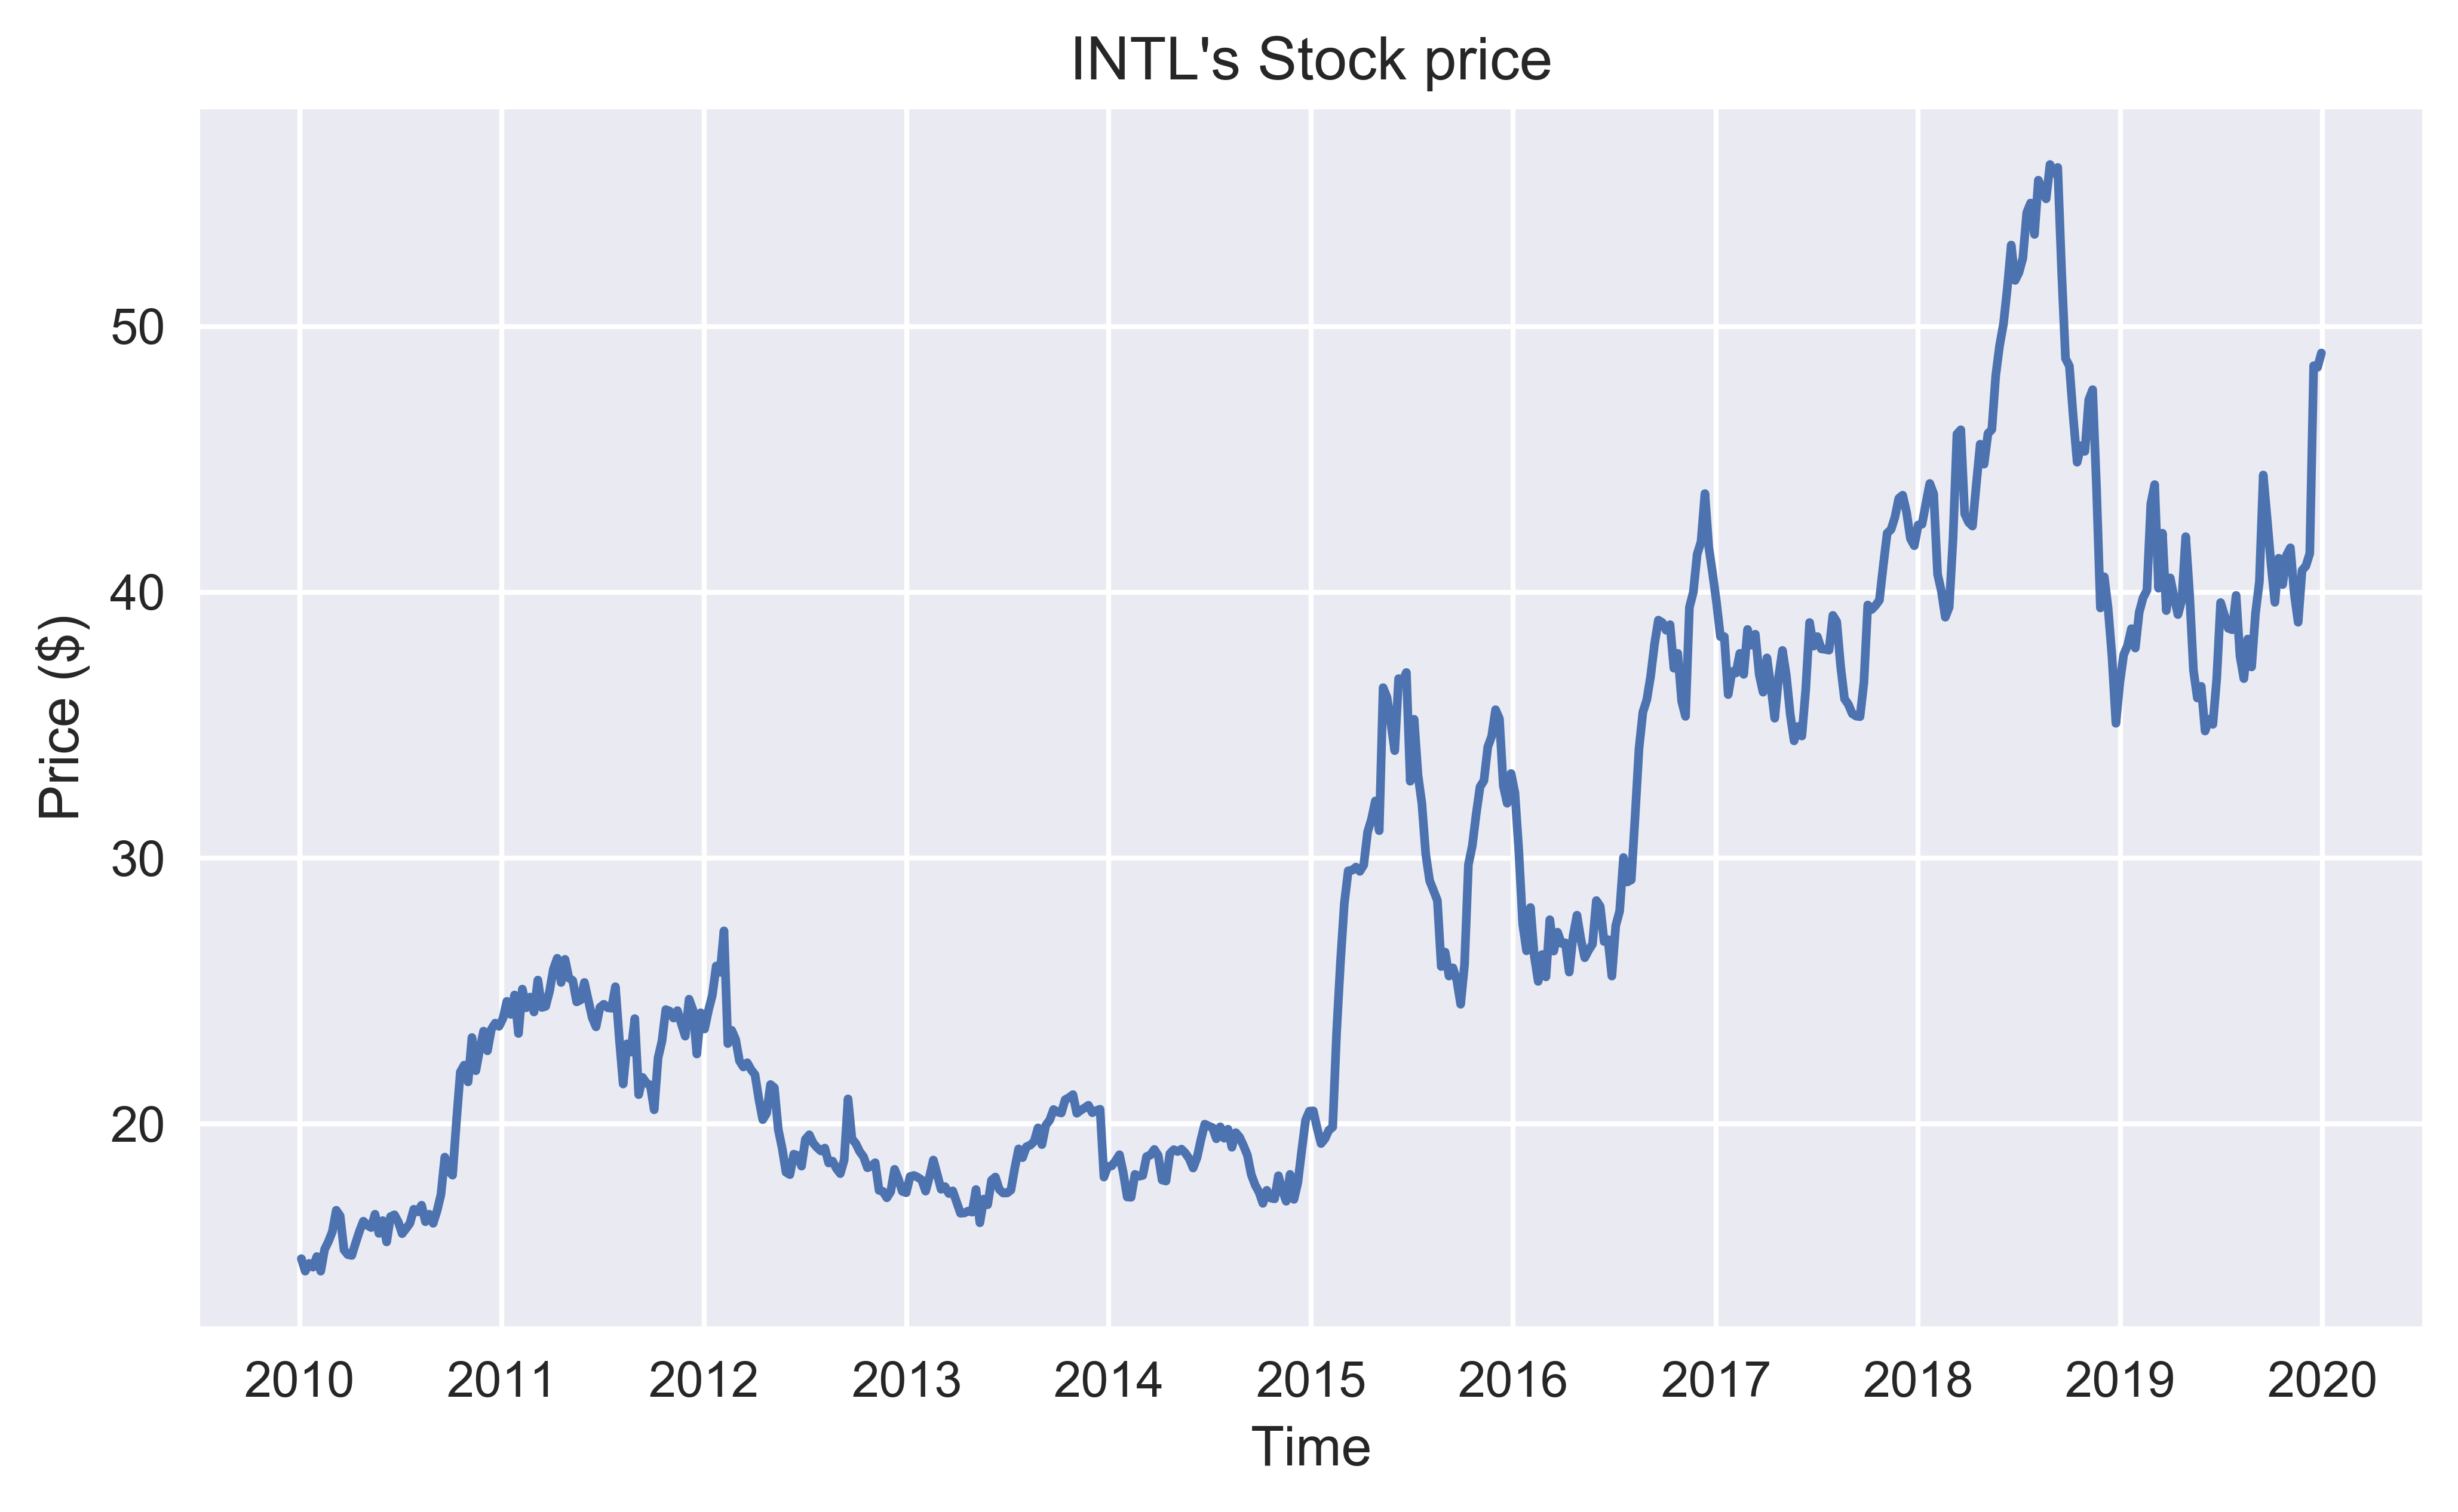

In [6]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Scale the time series of prices:

In [7]:
valid_ind = len(prices) - valid_size

minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()
#plt.plot(prices_scaled)

5. Transform the time series into input for the RNN:

In [8]:
X, y = create_input_data(prices_scaled, N_LAGS)

6. Obtain the naïve forecast:

In [9]:
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

Naive forecast - MSE: 4.1568, RMSE: 2.0388


7. Prepare the `DataLoader` objects:

In [10]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], 
                                               X.shape[1], 
                                               1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Check the size of the datasets:

In [11]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 483 | validation: 27


8. Define the model:

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          n_layers, batch_first=True,
                          nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:,-1,:]) 
        return output

9. Instantiate the model, the loss function and the optimizer:

In [13]:
model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

10. Train the network:

In [14]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './rnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 0.3088 	 Valid. loss: 0.3750
<10> - Train. loss: 0.0395 	 Valid. loss: 0.0587
<20> - Train. loss: 0.0371 	 Valid. loss: 0.0580
<30> - Train. loss: 0.0342 	 Valid. loss: 0.0532
<40> - Train. loss: 0.0331 	 Valid. loss: 0.0522
<50> - Train. loss: 0.0324 	 Valid. loss: 0.0516
<60> - Train. loss: 0.0310 	 Valid. loss: 0.0531
<70> - Train. loss: 0.0302 	 Valid. loss: 0.0490
<80> - Train. loss: 0.0296 	 Valid. loss: 0.0507
<90> - Train. loss: 0.0291 	 Valid. loss: 0.0481
Lowest loss recorded in epoch: 98


11. Plot the losses over epochs:

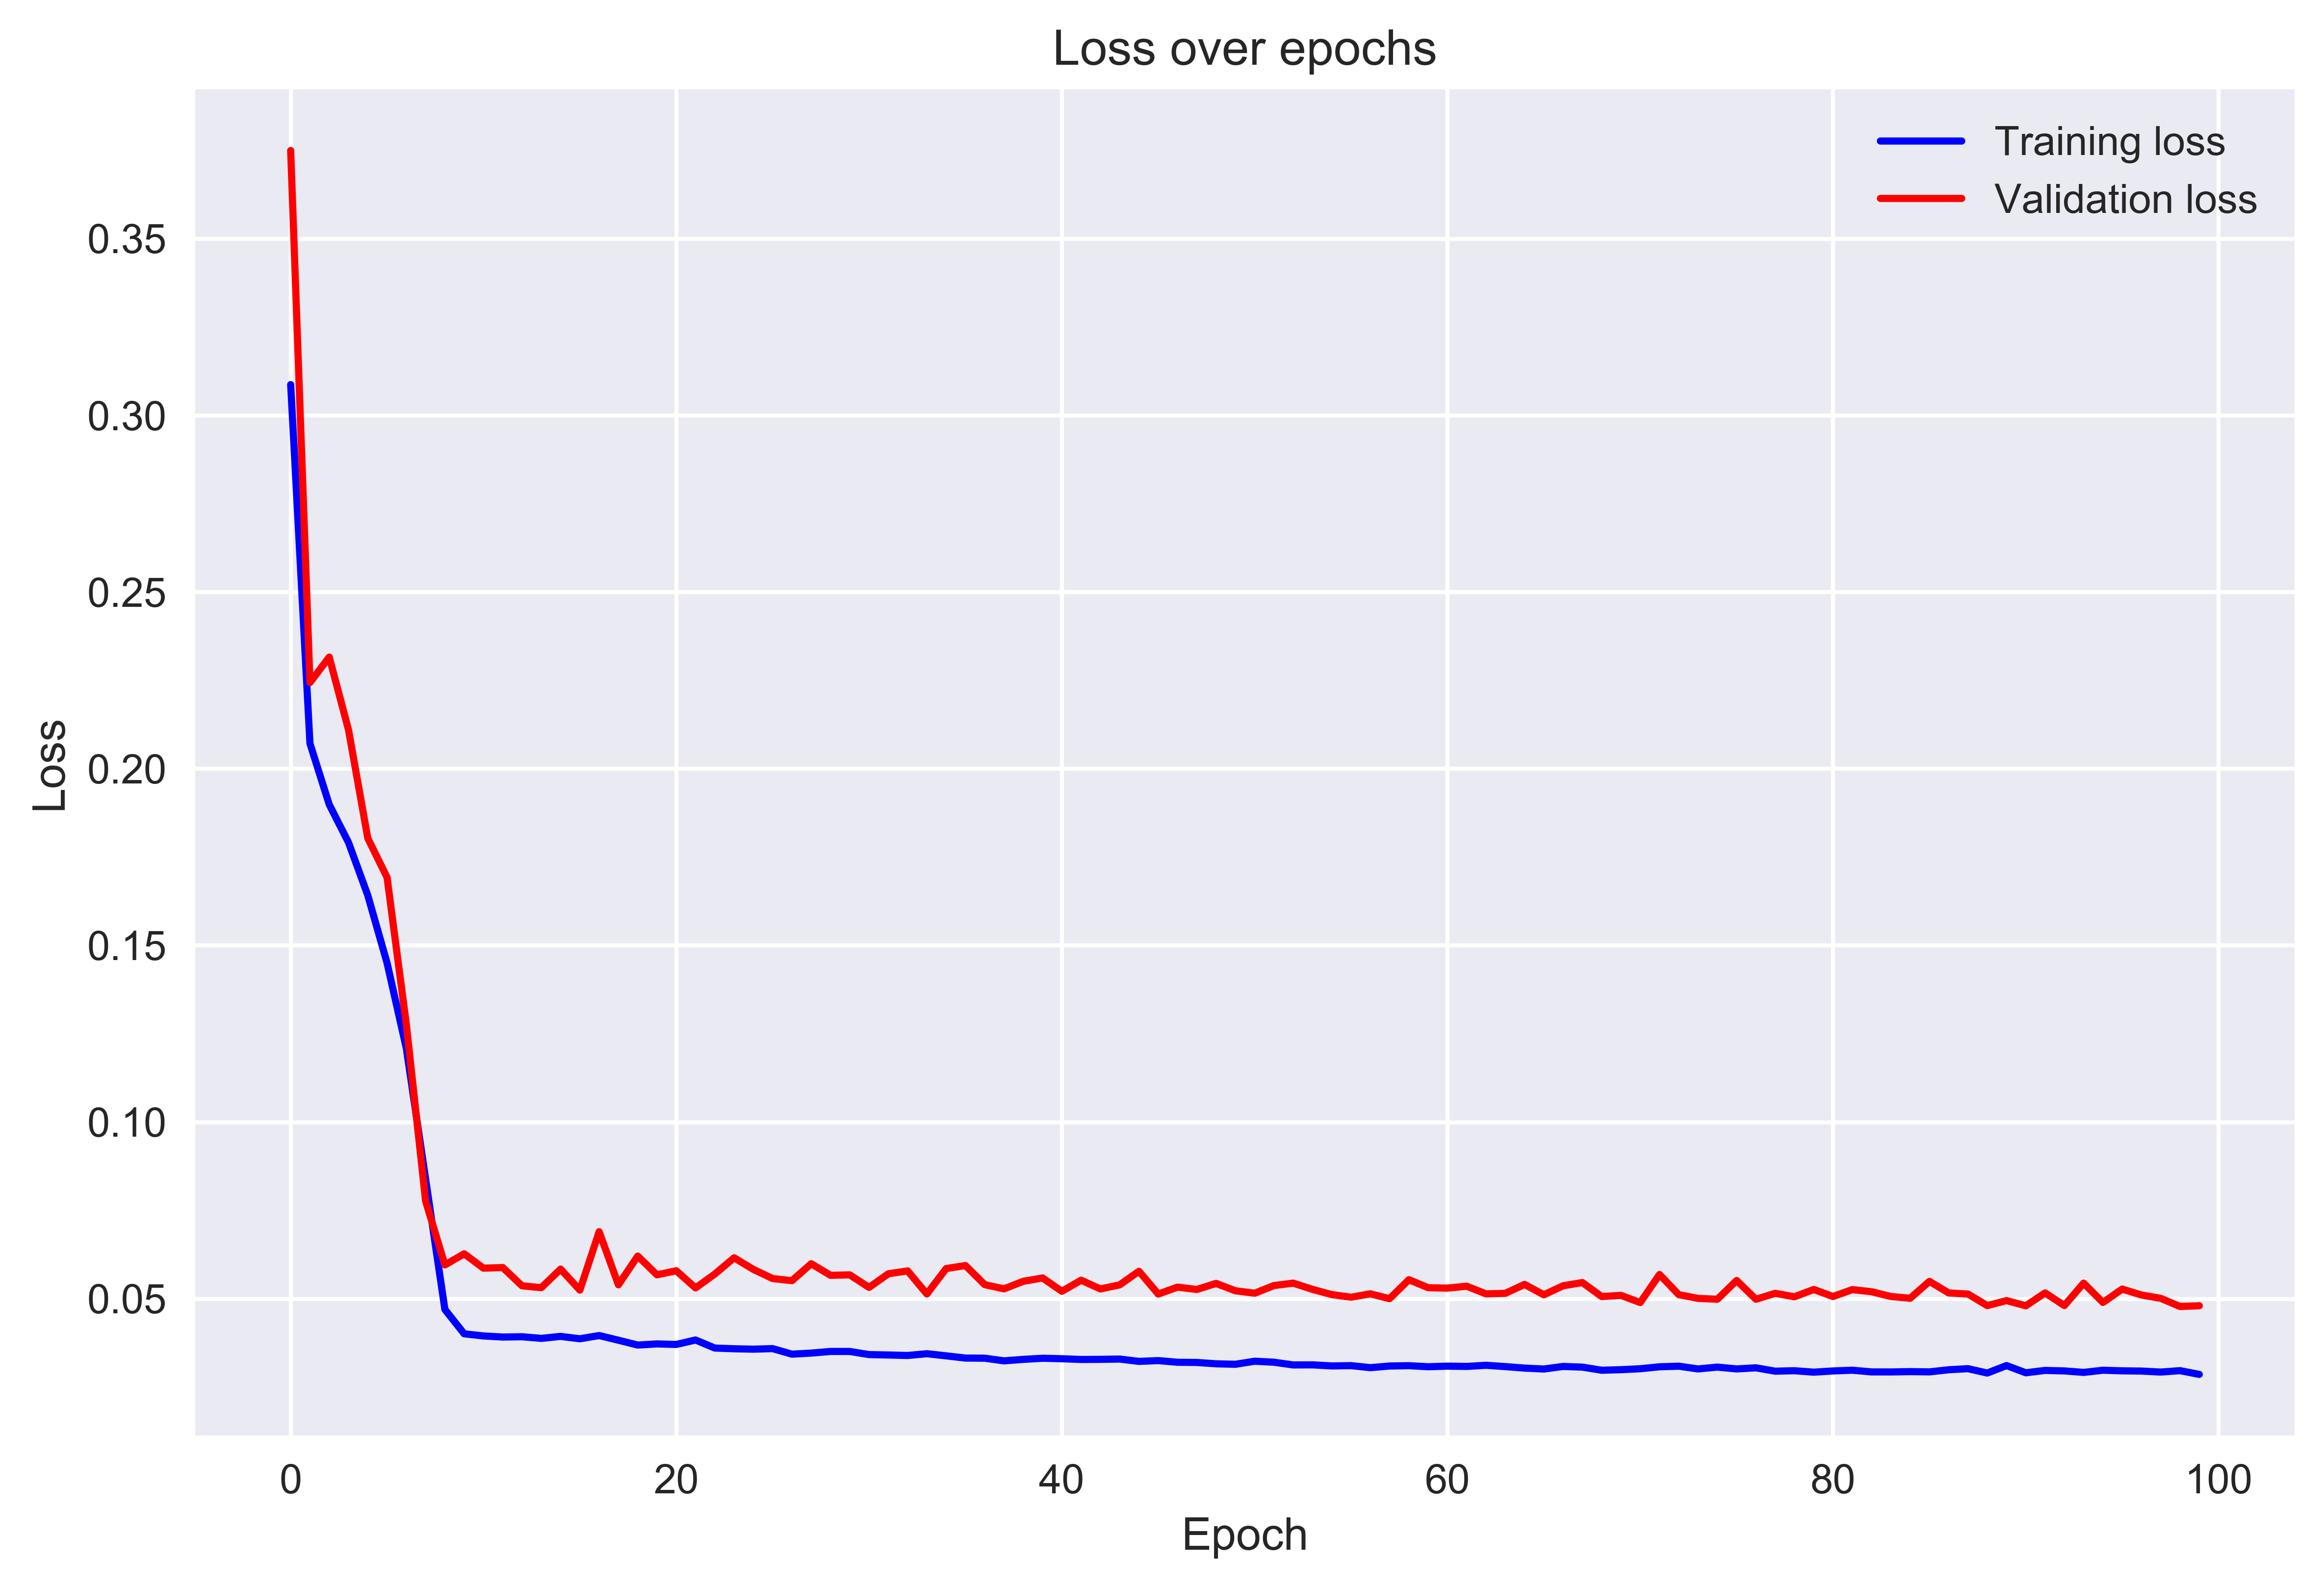

In [15]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im14.png')
plt.show()

12. Load the best model (with the lowest validation loss):

In [16]:
state_dict = torch.load('rnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

13. Obtain the predictions:

In [17]:
y_pred = []

with torch.no_grad():
    
    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)
        
y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten()

14. Evaluate the predictions:

RNN's forecast - MSE: 4.0315, RMSE: 2.0079


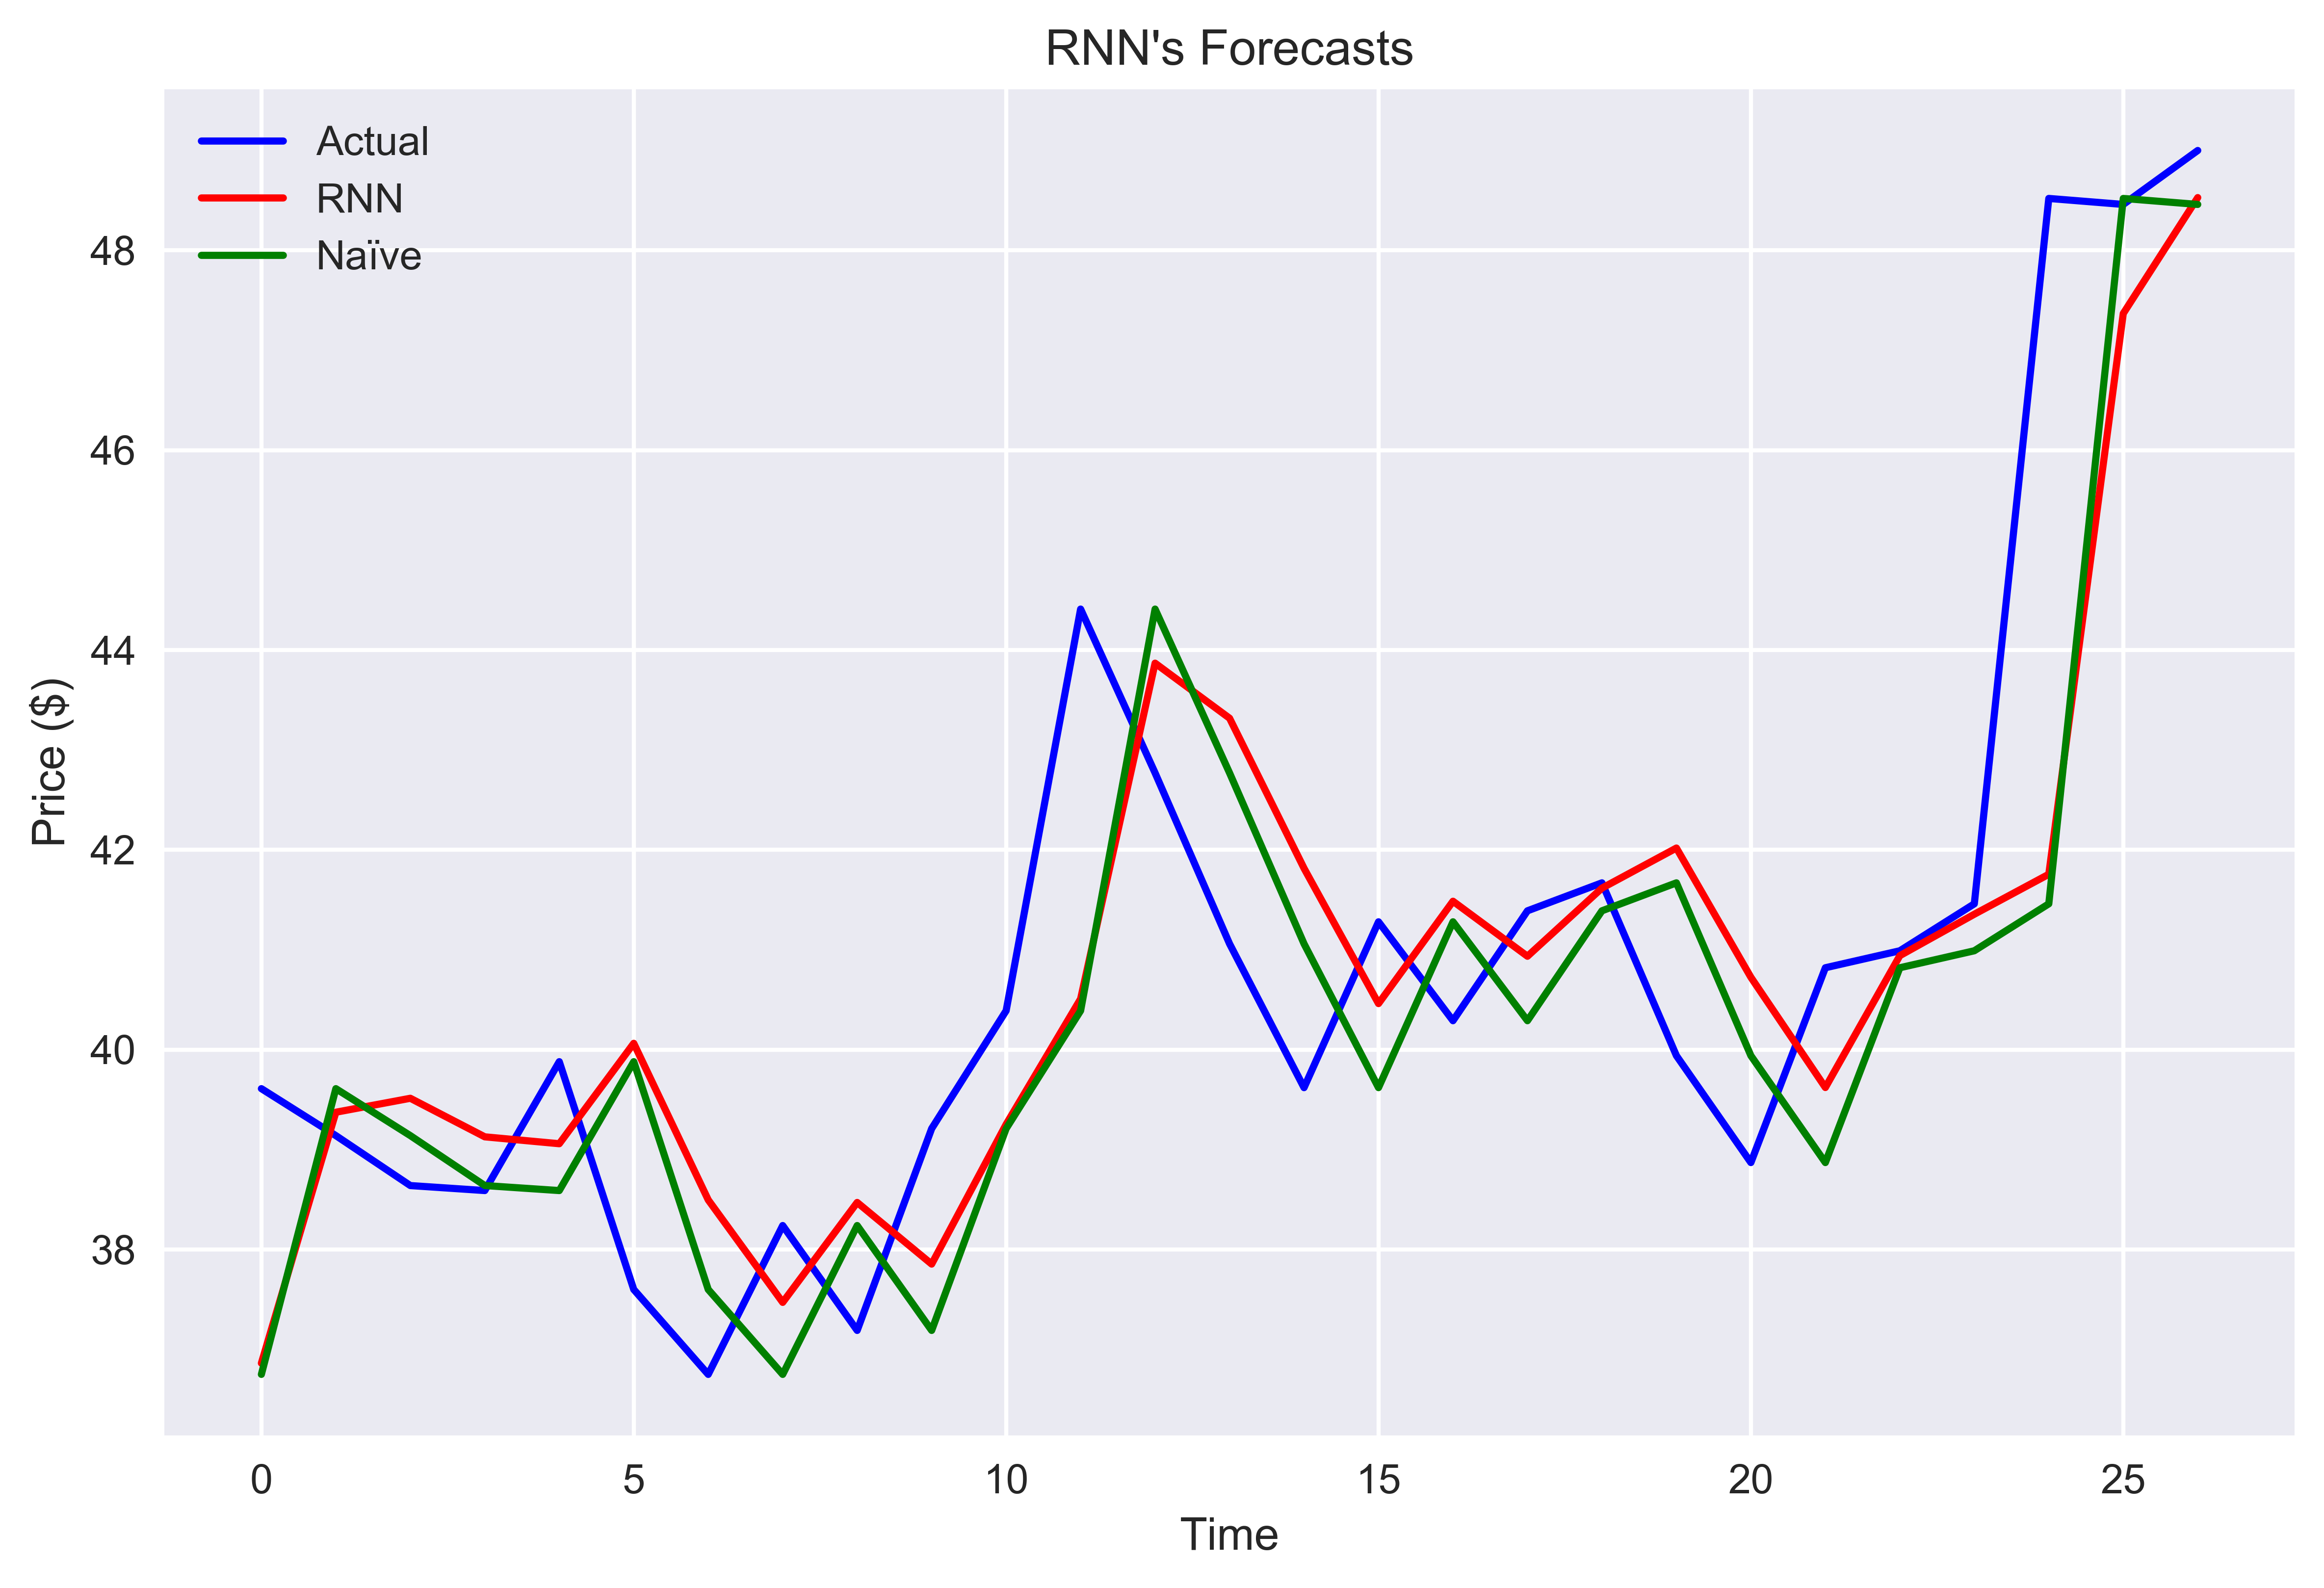

In [18]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
print(f"RNN's forecast - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='RNN')
ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="RNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
# plt.savefig('images/ch10_im15.png')
plt.show()